# Combine Signals for Enhanced Alpha

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper`,`factor_pipelines` and `no_overlap_classifier`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions.

### Load Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.data.data_portal import DataPortal

import project_helper
from risk_model import risk_modelling
from factors_pipeline import run_data_pipeline
from portfolio_optimizer import OptimalHoldingsStrictFactor
from no_overlap_classifier import NoOverlapVoter,non_overlapping_samples


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import alphalens as al
from alphalens.tears import create_full_tear_sheet

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Data Pipeline
### Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('XBOM') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

#### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using.

In [4]:
universe_end_date = pd.Timestamp('2020-05-15', tz='UTC')
factor_start_date = universe_end_date - pd.DateOffset(years=3,days=357)

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [3MINDIA.NS]),
 Equity(1 [AARTIIND.NS]),
 Equity(2 [ABBOTINDIA.NS]),
 Equity(3 [ABFRL.NS]),
 Equity(4 [ACC.NS]),
 Equity(5 [ADANIPORTS.NS]),
 Equity(6 [ADANIPOWER.NS]),
 Equity(7 [AEGISCHEM.NS]),
 Equity(8 [AIAENG.NS]),
 Equity(9 [AJANTPHARM.NS]),
 Equity(10 [AKZOINDIA.NS]),
 Equity(11 [ALLCARGO.NS]),
 Equity(12 [AMARAJABAT.NS]),
 Equity(13 [AMBUJACEM.NS]),
 Equity(14 [APLAPOLLO.NS]),
 Equity(15 [APLLTD.NS]),
 Equity(16 [APOLLOHOSP.NS]),
 Equity(17 [APOLLOTYRE.NS]),
 Equity(18 [ASAHIINDIA.NS]),
 Equity(19 [ASHOKA.NS]),
 Equity(20 [ASHOKLEY.NS]),
 Equity(21 [ASIANPAINT.NS]),
 Equity(22 [ASTRAL.NS]),
 Equity(23 [ASTRAZEN.NS]),
 Equity(24 [ATUL.NS]),
 Equity(25 [AUROPHARMA.NS]),
 Equity(26 [AVANTIFEED.NS]),
 Equity(27 [AXISBANK.NS]),
 Equity(28 [BAJAJ-AUTO.NS]),
 Equity(29 [BAJAJCON.NS]),
 Equity(30 [BAJAJELEC.NS]),
 Equity(31 [BAJAJFINSV.NS]),
 Equity(32 [BAJAJHLDNG.NS]),
 Equity(33 [BAJFINANCE.NS]),
 Equity(34 [BALKRISIND.NS]),
 Equity(35 [BALMLAWRIE.NS]),
 Equity(36 [BALRAMCH

### Get Returns
We have our pipeline built, let's access the returns data. We'll start by building a data portal.

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [5]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)


def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## Alpha Factors
It's time to start working on the alpha factors. In this project, we'll use the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor
- 15/30 Days RSI Of Returns
- RegressionAgainstTime to Compute Beta And Gamma

## Risk Factors
It's time to start working on the risk factors. In this project, we'll use the following factors:
- Sortino Ratio
- 3 Month Volatility

## Features and Labels
Let's create some features that we think will help the model make predictions.
### "Universal" Quant Features
To capture the universe, we'll use the following as features:
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

### Regime Features
We are going to try to capture market-wide regimes. To do that, we'll use the following features:
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

### Date Features
Let's make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

### Shift Target
We'll use shifted 5 day returns for training the model.

### Computing Factors Mentioned Above :-

In [6]:
all_factors = run_data_pipeline(engine,universe,factor_start_date,universe_end_date)

In [7]:
all_factors.head()

3 Month Volatility  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])               0.024891   
                          Equity(1 [AARTIIND.NS])              0.020729   
                          Equity(2 [ABBOTINDIA.NS])            0.014124   
                          Equity(3 [ABFRL.NS])                 0.034523   
                          Equity(4 [ACC.NS])                   0.014709   

                                                     Downside Risk (Sortino Ratio)  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                          0.156528   
                          Equity(1 [AARTIIND.NS])                         0.144902   
                          Equity(2 [ABBOTINDIA.NS])                       0.106799   
                          Equity(3 [ABFRL.NS])                            0.007969   
                          Equity(4 [ACC.NS])                             -0.009721   

                                                     Mean_Reversion_Sector_Neutral_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                                  -1.249207   
                          Equity(1 [AARTIIND.NS])                                 -0.575876   
                          Equity(2 [ABBOTINDIA.NS])                                0.761928   
                          Equity(3 [ABFRL.NS])                                     0.531577   
                          Equity(4 [ACC.NS])                                       0.416402   

                                                     Momentum_1YR  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])         1.390961   
                          Equity(1 [AARTIIND.NS])        1.506136   
                          Equity(2 [ABBOTINDIA.NS])      0.478420   
                          Equity(3 [ABFRL.NS])           0.336666   
                          Equity(4 [ACC.NS])            -0.097456   

                                                     Overnight_Sentiment_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                        -1.311224   
                          Equity(1 [AARTIIND.NS])                       -1.364382   
                          Equity(2 [ABBOTINDIA.NS])                      0.682191   
                          Equity(3 [ABFRL.NS])                          -0.504999   
                          Equity(4 [ACC.NS])                            -1.151751   

                                                     RSI_Sector_Neutral_15d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                  -1.107453   
                          Equity(1 [AARTIIND.NS])                 -0.318946   
                          Equity(2 [ABBOTINDIA.NS])                1.116313   
                          Equity(3 [ABFRL.NS])                     1.275786   
                          Equity(4 [ACC.NS])                       0.425262   

                                                     RSI_Sector_Neutral_30d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                   1.709907   
                          Equity(1 [AARTIIND.NS])                 -0.947980   
                          Equity(2 [ABBOTINDIA.NS])                1.568153   
                          Equity(3 [ABFRL.NS])                     0.434122   
                          Equity(4 [ACC.NS])                      -0.939120   

                                                     adv_120d   adv_20d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])    -0.965699 -1.196049   
                          Equity(1 [AARTIIND.NS])   -0.930261 -0.584735   
                          Equity(2 [ABBOTINDIA.NS]) -1.009997 -1.470698   
                          Equity(3 [ABFRL.NS])       0.327806 -0.177192   
                          Equity(4 [ACC.NS])         0.815085  0.894822   

                                                     conditional_factor  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])              -1.647890   
                          Equity(1 [A

### Train/Valid/Test Splits
Now let's split the data into a train, validation, and test dataset. Implement the function `train_valid_test_split` to split the input samples, `all_x`, and targets values, `all_y` into a train, validation, and test dataset. The proportion sizes are `train_size`, `valid_size`, `test_size` respectively.

When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [8]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    train_end_index = int(len(all_x.index.levels[0].tolist())*train_size)
    valid_end_index = train_end_index + int(len(all_x.index.levels[0].tolist())*valid_size)
    test_end_index = valid_end_index + int(len(all_x.index.levels[0].tolist())*test_size)
    
    x_train,y_train = all_x.loc[all_x.index.levels[0].tolist()[:train_end_index]],all_y.loc[all_y.index.levels[0].tolist()[:train_end_index]]
    x_valid,y_valid = all_x.loc[all_x.index.levels[0].tolist()[train_end_index:valid_end_index]],all_y.loc[all_y.index.levels[0].tolist()[train_end_index:valid_end_index]]
    x_test,y_test = all_x.loc[all_x.index.levels[0].tolist()[valid_end_index:]],all_y.loc[all_y.index.levels[0].tolist()[valid_end_index:]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test


With `train_valid_test_split` implemented, let's split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [9]:
sector_columns= ['sector_SERVICES',
                 'sector_CEMENT & CEMENT PRODUCTS',
                 'sector_INDUSTRIAL MANUFACTURING',
                 'sector_METALS',
                 'sector_FINANCIAL SERVICES',
                 'sector_CHEMICALS',
                 'sector_PHARMA',
                 'sector_OIL & GAS',
                 'sector_POWER',
                 'sector_CONSUMER GOODS',
                 'sector_IT',
                 'sector_AUTOMOBILE',
                 'sector_HEALTHCARE SERVICES',
                 'sector_CONSTRUCTION',
                 'sector_FERTILISERS & PESTICIDES',
                 'sector_TELECOM',
                 'sector_MEDIA & ENTERTAINMENT',
                 'sector_TEXTILES',
                 'sector_PAPER']

features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'RSI_Sector_Neutral_15d','RSI_Sector_Neutral_30d',
    '3 Month Volatility','Downside Risk (Sortino Ratio)',
    'time_beta','time_gamma','conditional_factor',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_March', 'is_April', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns

target_label = 'target'

temp = all_factors.fillna(method = 'bfill').copy()
temp = temp.fillna(0)
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                                  -1.249207   
                          Equity(1 [AARTIIND.NS])                                 -0.575876   
                          Equity(2 [ABBOTINDIA.NS])                                0.761928   
                          Equity(3 [ABFRL.NS])                                     0.531577   
                          Equity(4 [ACC.NS])                                       0.416402   

                                                     Momentum_1YR  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])         1.390961   
                          Equity(1 [AARTIIND.NS])        1.506136   
                          Equity(2 [ABBOTINDIA.NS])      0.478420   
                          Equity(3 [ABFRL.NS])           0.336666   
                          Equity(4 [ACC.NS])            -0.097456   

                                                     RSI_Sector_Neutral_15d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                  -1.107453   
                          Equity(1 [AARTIIND.NS])                 -0.318946   
                          Equity(2 [ABBOTINDIA.NS])                1.116313   
                          Equity(3 [ABFRL.NS])                     1.275786   
                          Equity(4 [ACC.NS])                       0.425262   

                                                     RSI_Sector_Neutral_30d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                   1.709907   
                          Equity(1 [AARTIIND.NS])                 -0.947980   
                          Equity(2 [ABBOTINDIA.NS])                1.568153   
                          Equity(3 [ABFRL.NS])                     0.434122   
                          Equity(4 [ACC.NS])                      -0.939120   

                                                     3 Month Volatility  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])               0.024891   
                          Equity(1 [AARTIIND.NS])              0.020729   
                          Equity(2 [ABBOTINDIA.NS])            0.014124   
                          Equity(3 [ABFRL.NS])                 0.034523   
                          Equity(4 [ACC.NS])                   0.014709   

                                                     Downside Risk (Sortino Ratio)  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                          0.156528   
                          Equity(1 [AARTIIND.NS])                         0.144902   
                          Equity(2 [ABBOTINDIA.NS])                       0.106799   
                          Equity(3 [ABFRL.NS])                            0.007969   
                          Equity(4 [ACC.NS])                             -0.009721   

                                                     time_beta  time_gamma  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])      1.718767   -1.674469   
                          Equity(1 [AARTIIND.NS])     1.231488   -1.098593   
                          Equity(2 [ABBOTINDIA.NS])   1.709907   -1.718767   
                          Equity(3 [ABFRL.NS])        1.142891   -1.258067   
                          Equity(4 [ACC.NS])         -1.559294    1.603592   

                                                     conditional_factor  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])              -1.647890   
                          Equity(1 [AARTIIND.NS])             -0.717630   
                          Equity(2 [ABBOTINDIA.NS])           -1.701048   
                          Equity(3 [ABFRL.NS])                -0.797366   
                          Equity(4 [ACC.NS])                  -1.435259   

                                                     Overnight_Sentiment_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                        -1.311224   
                          Equity(1 [AARTIIND.NS])          

In [10]:
i = 1
print('Features :')
for value in X_train.columns.values:
    print('{}. {}'.format(i,value))
    i += 1

Features :
1. Mean_Reversion_Sector_Neutral_Smoothed
2. Momentum_1YR
3. RSI_Sector_Neutral_15d
4. RSI_Sector_Neutral_30d
5. 3 Month Volatility
6. Downside Risk (Sortino Ratio)
7. time_beta
8. time_gamma
9. conditional_factor
10. Overnight_Sentiment_Smoothed
11. adv_120d
12. adv_20d
13. dispersion_120d
14. dispersion_20d
15. market_vol_120d
16. market_vol_20d
17. volatility_20d
18. is_March
19. is_April
20. weekday
21. month_end
22. month_start
23. qtr_end
24. qtr_start
25. sector_SERVICES
26. sector_CEMENT & CEMENT PRODUCTS
27. sector_INDUSTRIAL MANUFACTURING
28. sector_METALS
29. sector_FINANCIAL SERVICES
30. sector_CHEMICALS
31. sector_PHARMA
32. sector_OIL & GAS
33. sector_POWER
34. sector_CONSUMER GOODS
35. sector_IT
36. sector_AUTOMOBILE
37. sector_HEALTHCARE SERVICES
38. sector_CONSTRUCTION
39. sector_FERTILISERS & PESTICIDES
40. sector_TELECOM
41. sector_MEDIA & ENTERTAINMENT
42. sector_TEXTILES
43. sector_PAPER


### Factor Names To Compare Against AI Alpha
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [11]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'time_beta',
    'time_gamma']

### Model Results
Let's look at some additional metrics to see how well a model performs. We've created the function `show_sample_results` to show the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation
- Information Tear Sheet
- Returns Tear Sheet

In [12]:
all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(data_portal,trading_calendar,all_assets,factor_start_date,universe_end_date)

In [13]:
def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_Alpha'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n--------------------------------------------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    print('             AI ALPHA :-')
    create_full_tear_sheet(factor_data['AI_Alpha'])
    print('\n--------------------------------------------------------\n')
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)


# Modelling And Evaluation

## Random Forests
### Checking a Simple Tree
Let's see how a single tree would look using our data.

In [14]:
# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)

simple_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [15]:
n_days = 10
n_stocks = 400

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}

n_trees_l = [50, 100, 250, 500, 1000]

We’ll choose a min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.  We can first propose 500, which is the number of assets in the estimation universe. Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative.  It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. If we were to try these values, we’d notice that the model is “too good to be true” on the training data.  A good rule of thumb for what is considered “too good to be true”, and therefore a sign of overfitting, is if the sharpe ratio is greater than 4.  Based on this, we recommend using min_sampes_leaf of 10 * 500, or 5,000.

Feel free to try other values for these parameters, but also keep in mind that making too many small adjustments to hyper-parameters can lead to overfitting even the validation data, and therefore lead to less generalizable performance on the out-of-sample test set.  So when trying different parameter values, choose values that are different enough in scale (i.e. 10, 20, 100 instead of 10,11,12).

In [16]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [05:23<00:00, 64.77s/Model]


Let's look at the accuracy of the classifiers over the number of trees.

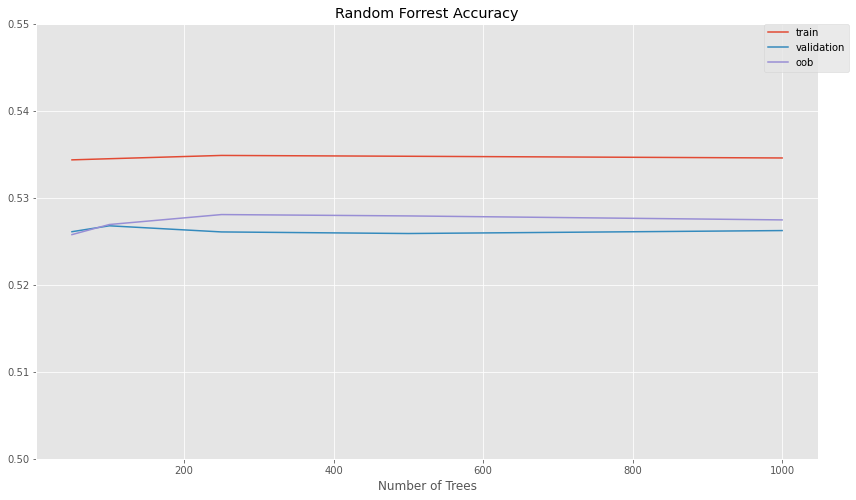

In [17]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

##### Training Prediction
Let's see how well the model runs on training data.

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.079727 -0.012579 -0.039192  0.010918  46373  20.204604
2               -0.041440  0.002839 -0.018303  0.006748  45786  19.948849
3               -0.022954  0.014629 -0.003831  0.006389  45786  19.948849
4               -0.006097  0.030731  0.012128  0.007123  45786  19.948849
5                0.007811  0.086985  0.036760  0.012197  45786  19.948849

Returns Analysis


1D
Ann. alpha                                      0.218
beta                                           -0.147
Mean Period Wise Return Top Quantile (bps)      6.359
Mean Period Wise Return Bottom Quantile (bps)  -8.520
Mean Period Wise Spread (bps)                  14.879

<Figure size 1008x576 with 0 Axes>

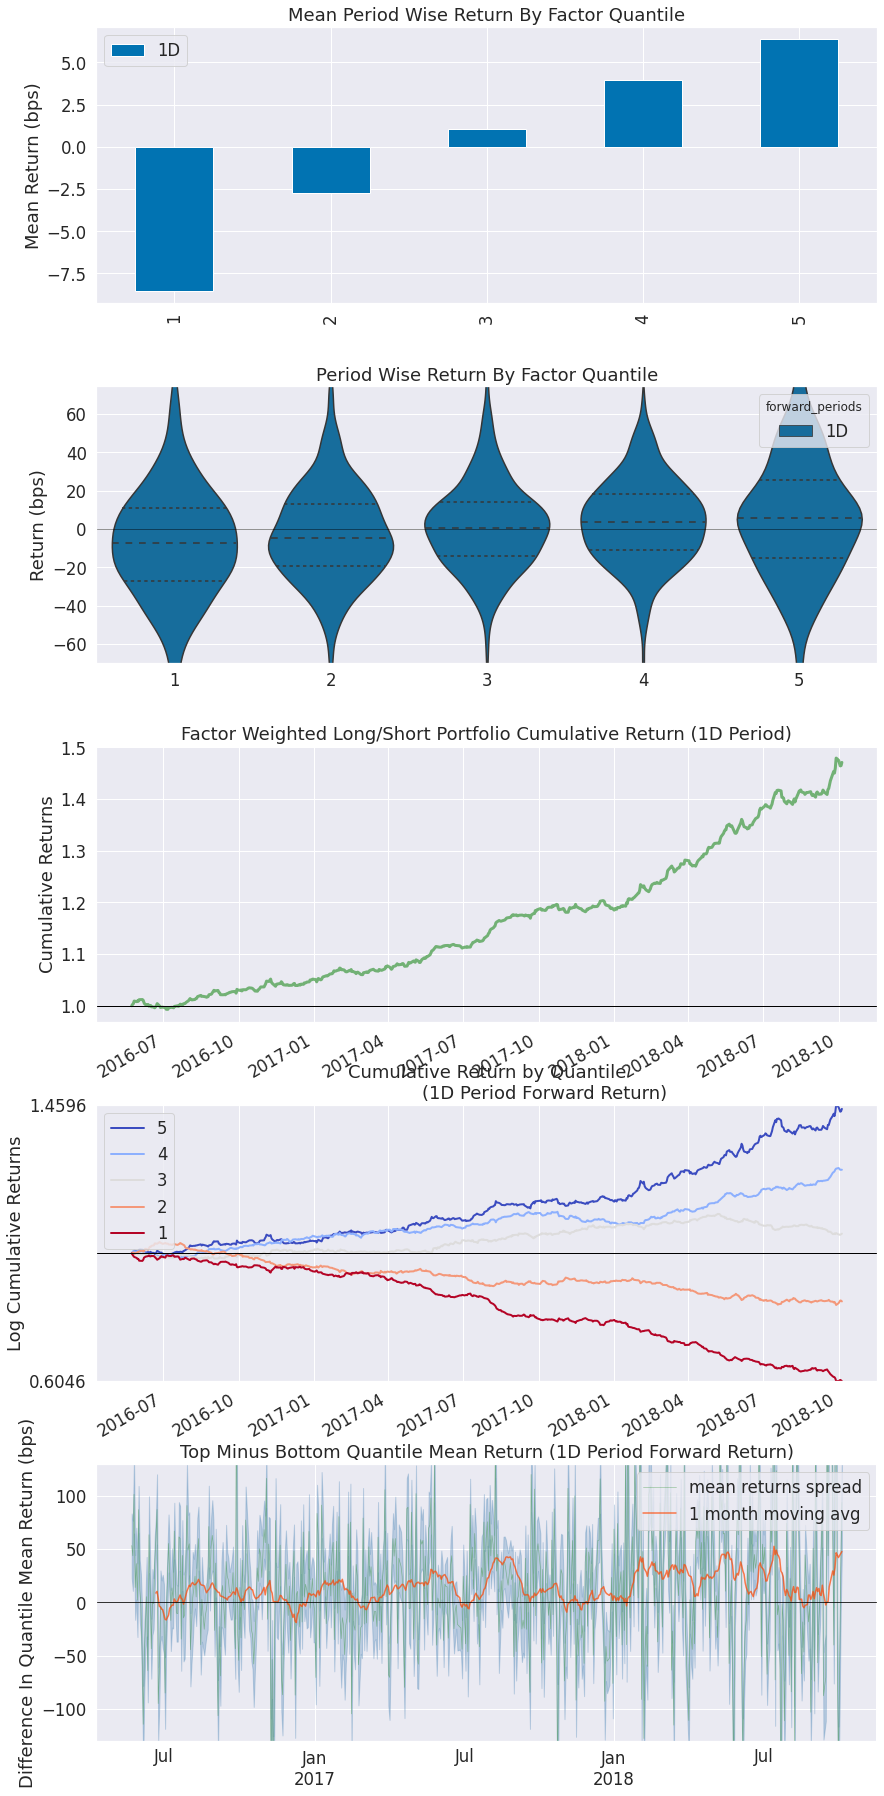

Information Analysis


1D
IC Mean            0.052
IC Std.            0.101
Risk-Adjusted IC   0.515
t-stat(IC)        12.480
p-value(IC)        0.000
IC Skew            0.070
IC Kurtosis        0.144

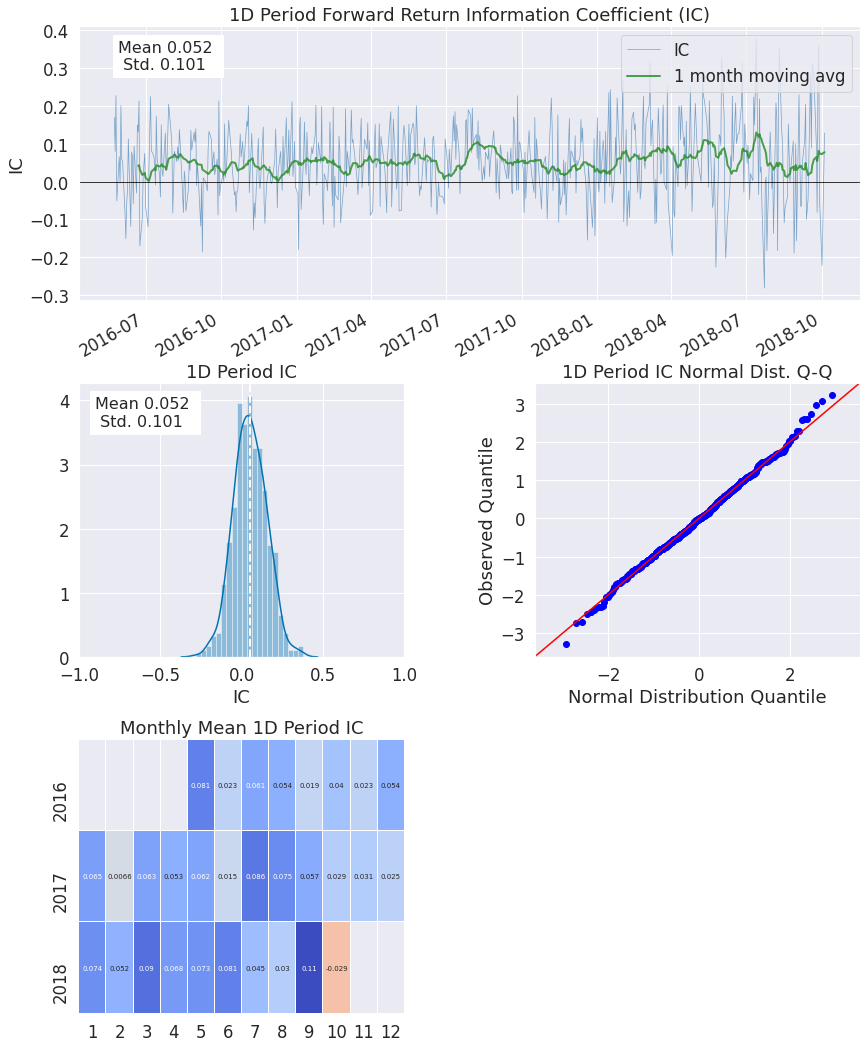

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.109
Quantile 2 Mean Turnover   0.249
Quantile 3 Mean Turnover   0.274
Quantile 4 Mean Turnover   0.229
Quantile 5 Mean Turnover   0.096

1D
Mean Factor Rank Autocorrelation  0.974

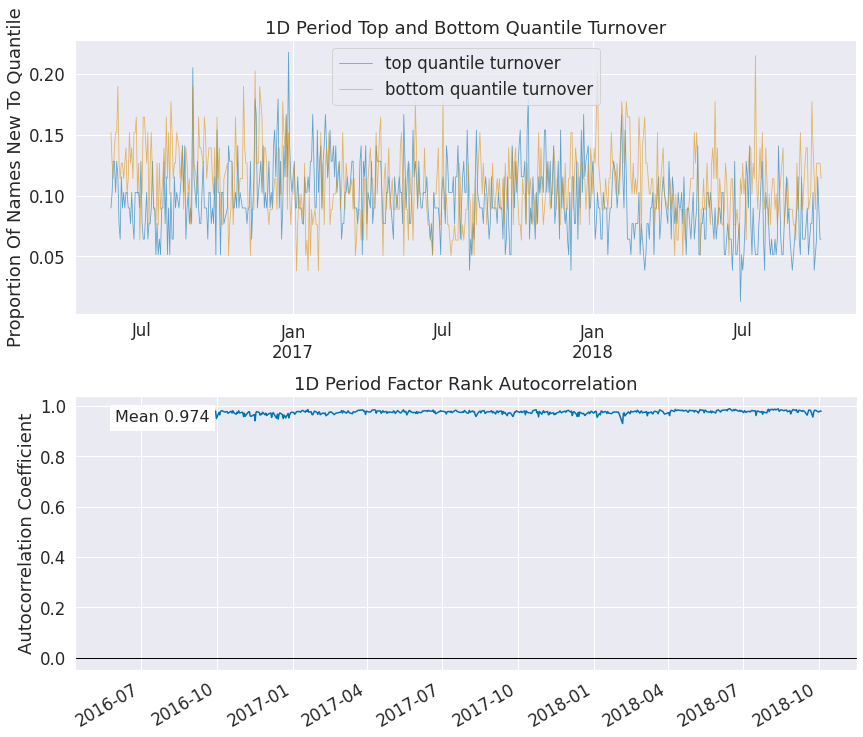


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed   -0.67
Momentum_1YR                              2.33
Overnight_Sentiment_Smoothed              1.16
time_beta                                 0.63
time_gamma                                0.04
AI_Alpha                                  4.15
dtype: float64


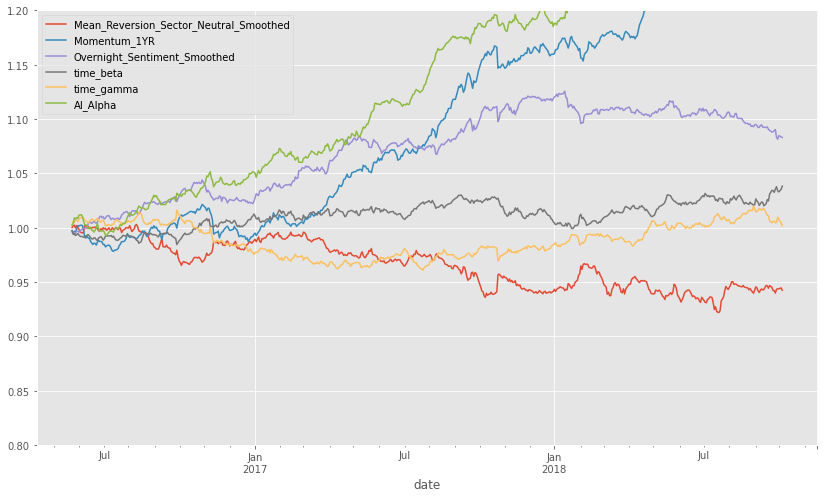

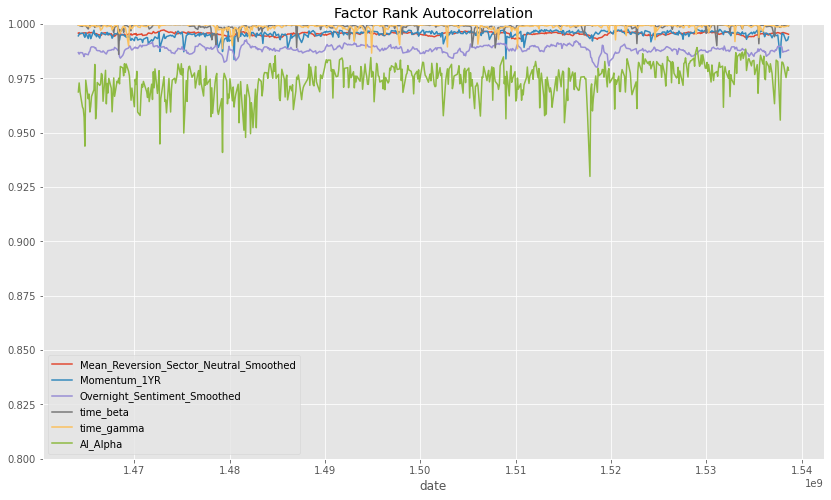

In [18]:
show_sample_results(all_factors, X_train, clf, factor_names)

##### Validation Prediction
Let's see how well the model runs on validation data.

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.070171 -0.023500 -0.040840  0.008294  15484  20.204604
2               -0.044953 -0.012885 -0.025040  0.005144  15288  19.948849
3               -0.024550  0.000960 -0.011779  0.004501  15288  19.948849
4               -0.009819  0.021862  0.002817  0.005661  15288  19.948849
5                0.005221  0.079685  0.027687  0.014320  15288  19.948849

Returns Analysis


1D
Ann. alpha                                     0.087
beta                                          -0.267
Mean Period Wise Return Top Quantile (bps)     1.653
Mean Period Wise Return Bottom Quantile (bps) -6.004
Mean Period Wise Spread (bps)                  7.658

<Figure size 1008x576 with 0 Axes>

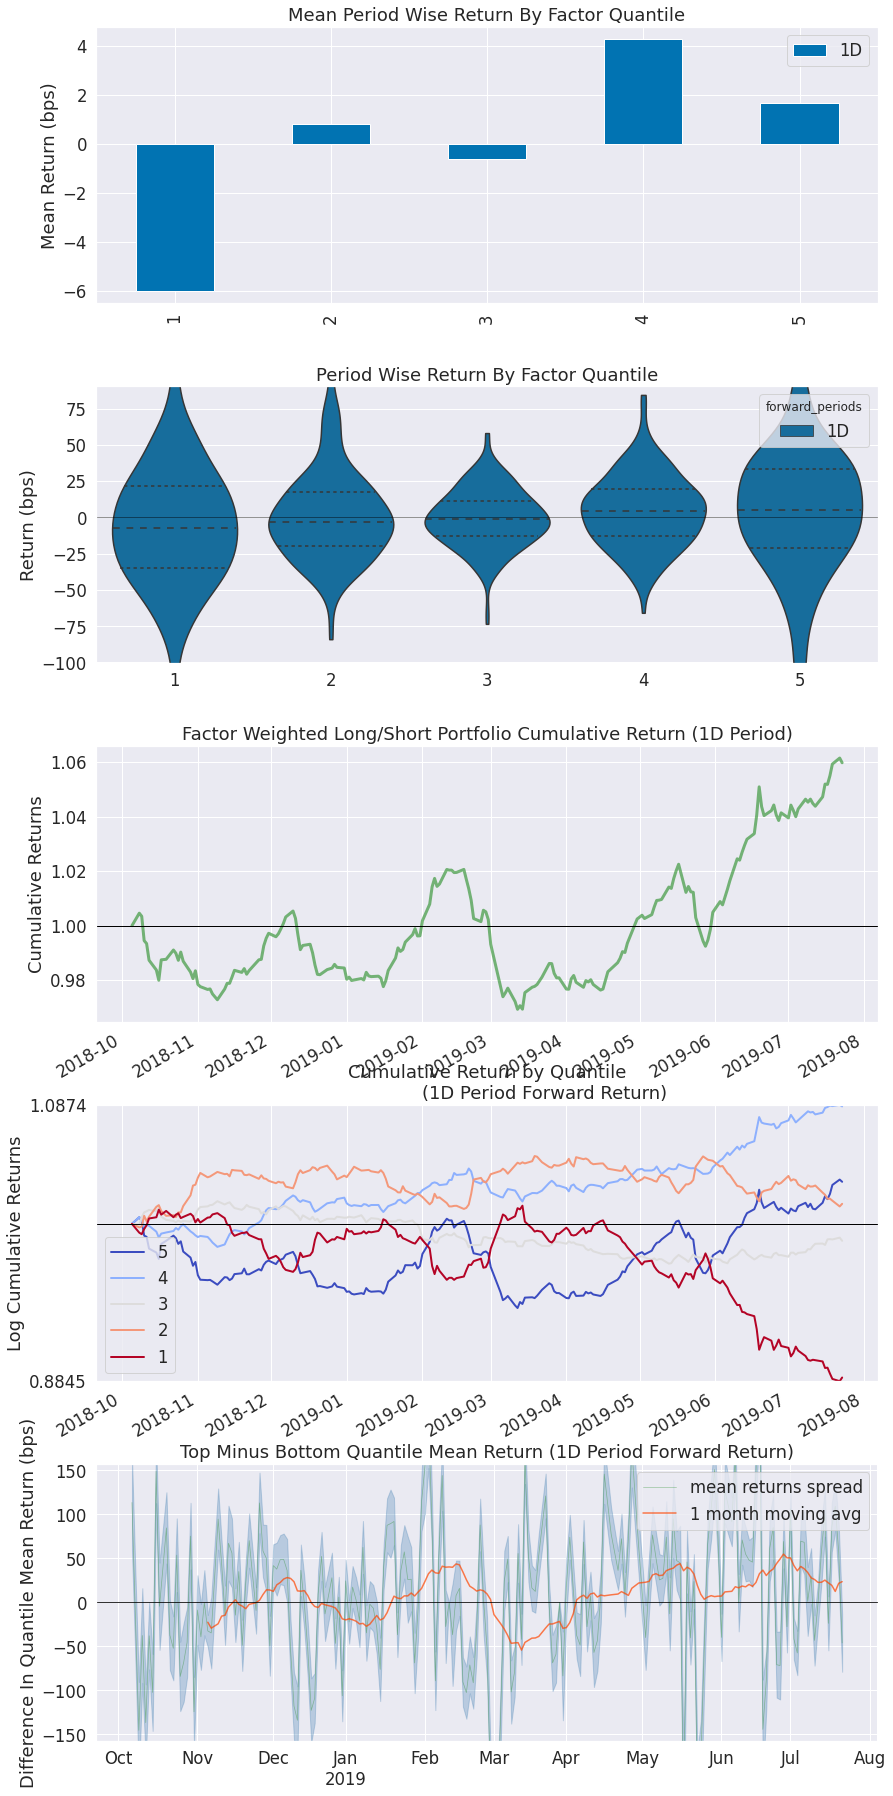

Information Analysis


1D
IC Mean           0.046
IC Std.           0.133
Risk-Adjusted IC  0.349
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

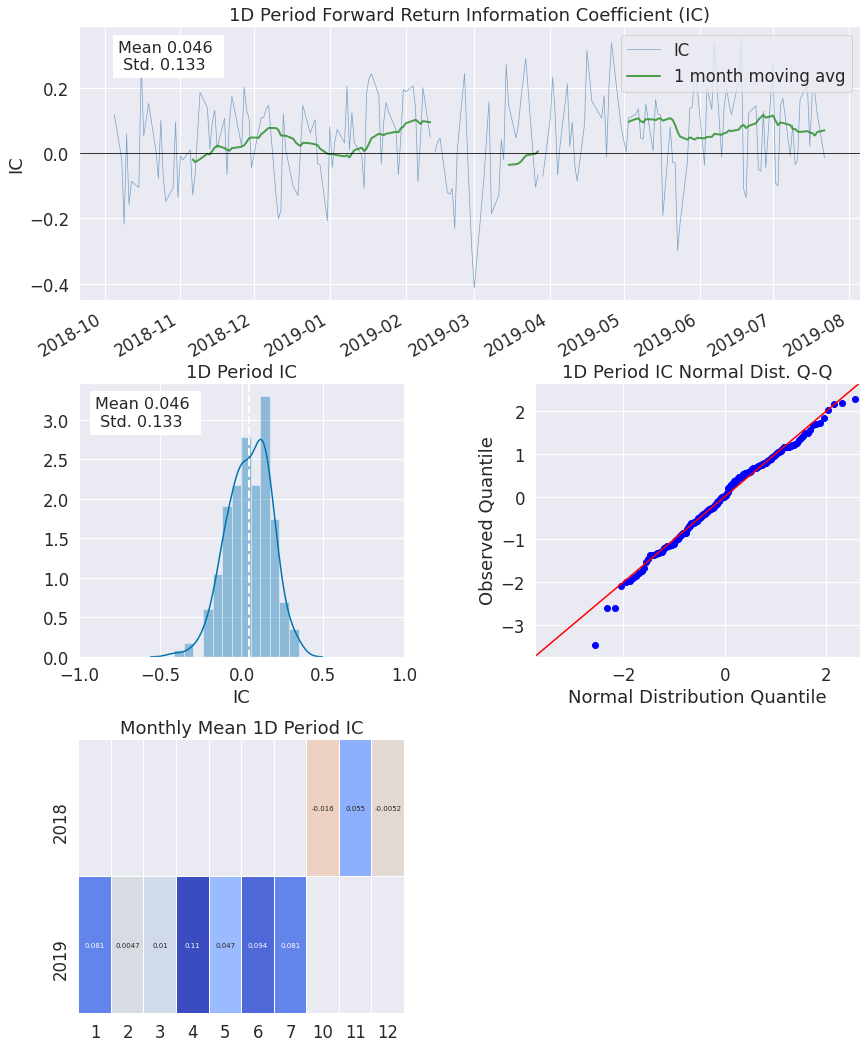

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.124
Quantile 2 Mean Turnover   0.253
Quantile 3 Mean Turnover   0.255
Quantile 4 Mean Turnover   0.208
Quantile 5 Mean Turnover   0.086

1D
Mean Factor Rank Autocorrelation  0.975

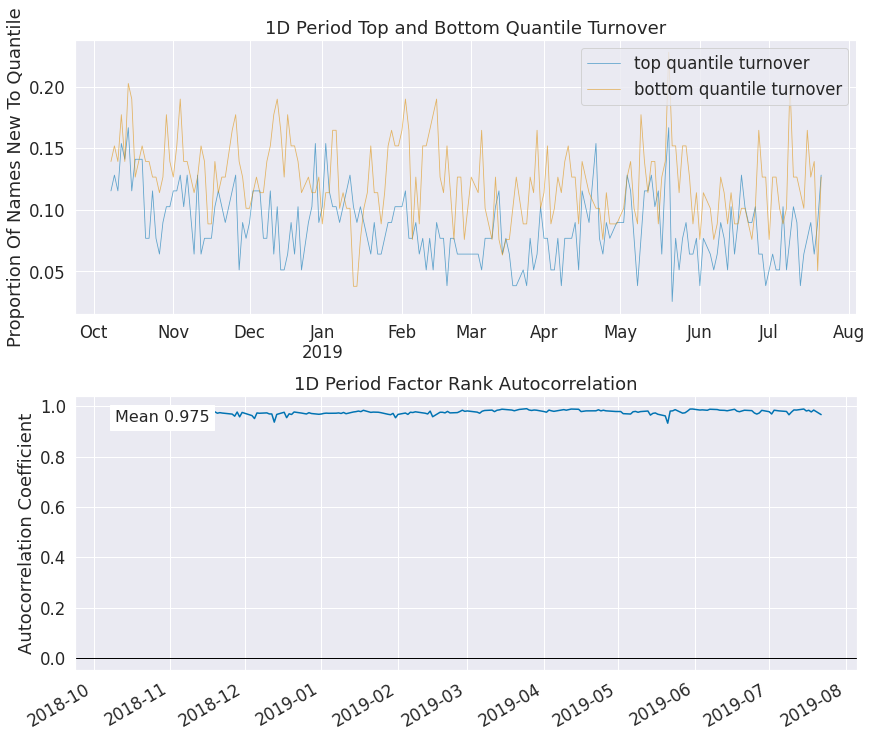


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    2.04
Momentum_1YR                              0.75
Overnight_Sentiment_Smoothed             -2.41
time_beta                                -0.04
time_gamma                                1.40
AI_Alpha                                  1.33
dtype: float64


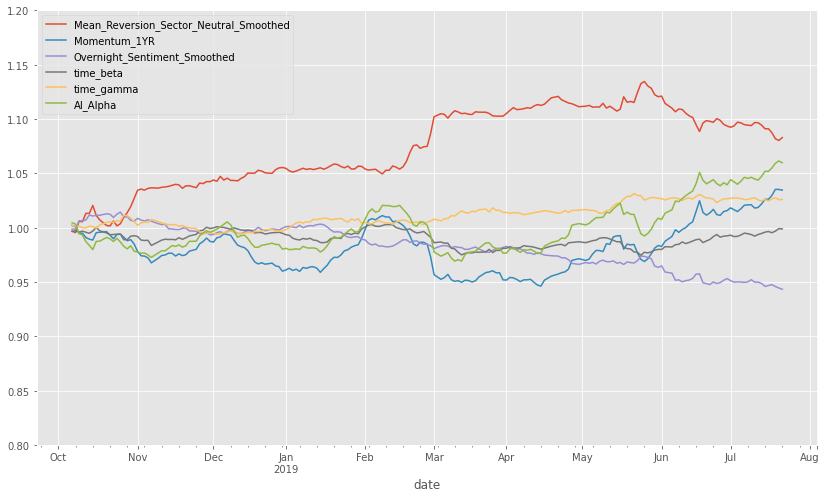

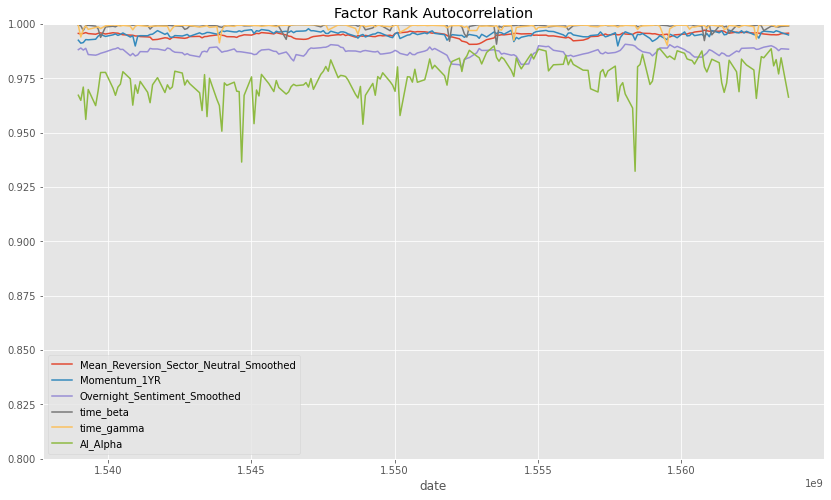

In [19]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Build an ensemble of non-overlapping trees

In this project, we'll do all two methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [20]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [00:50<00:00, 10.13s/Model]


#### Results

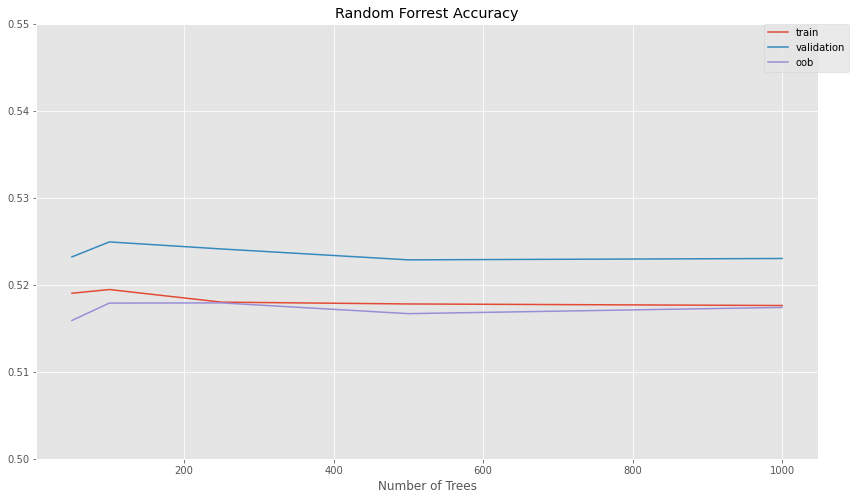

In [21]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.052977 -0.024137 -0.034823  0.005328  15484  20.204604
2               -0.032052 -0.013814 -0.022496  0.003573  15288  19.948849
3               -0.020126  0.000572 -0.011114  0.004080  15288  19.948849
4               -0.010823  0.015583  0.001807  0.005282  15288  19.948849
5                0.001123  0.045076  0.019433  0.008888  15288  19.948849

Returns Analysis


1D
Ann. alpha                                     0.085
beta                                          -0.350
Mean Period Wise Return Top Quantile (bps)     2.497
Mean Period Wise Return Bottom Quantile (bps) -4.948
Mean Period Wise Spread (bps)                  7.445

<Figure size 1008x576 with 0 Axes>

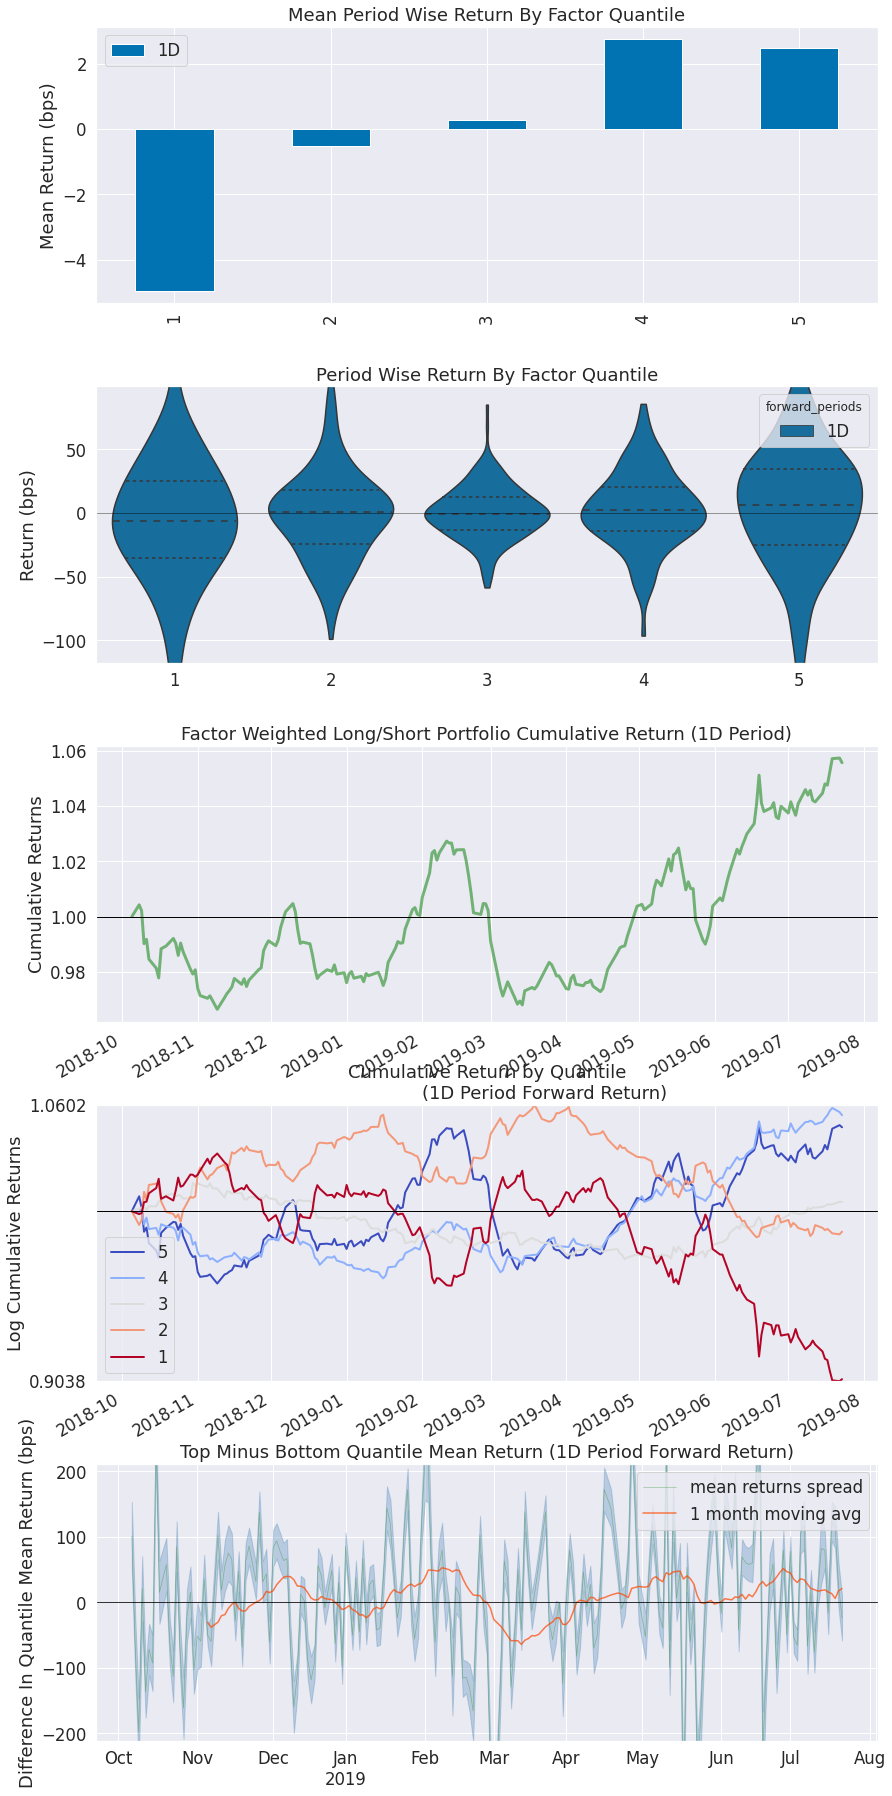

Information Analysis


1D
IC Mean           0.042
IC Std.           0.164
Risk-Adjusted IC  0.259
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

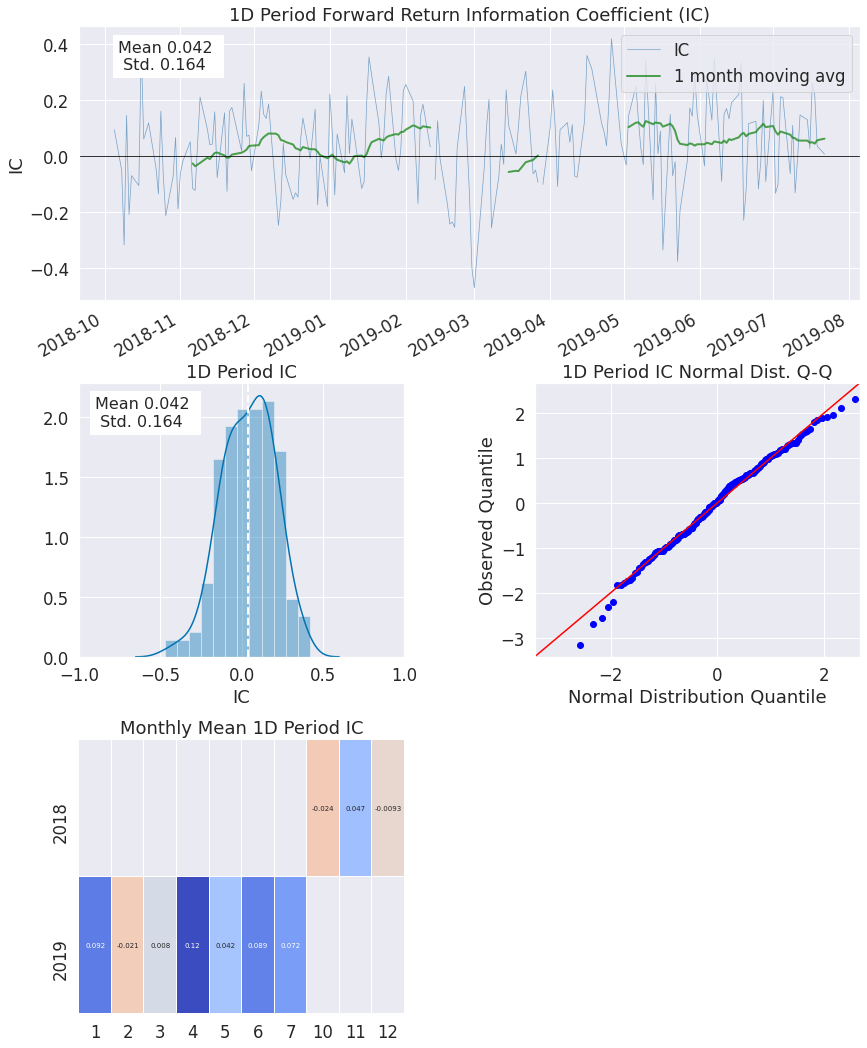

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.126
Quantile 2 Mean Turnover   0.248
Quantile 3 Mean Turnover   0.233
Quantile 4 Mean Turnover   0.189
Quantile 5 Mean Turnover   0.082

1D
Mean Factor Rank Autocorrelation  0.978

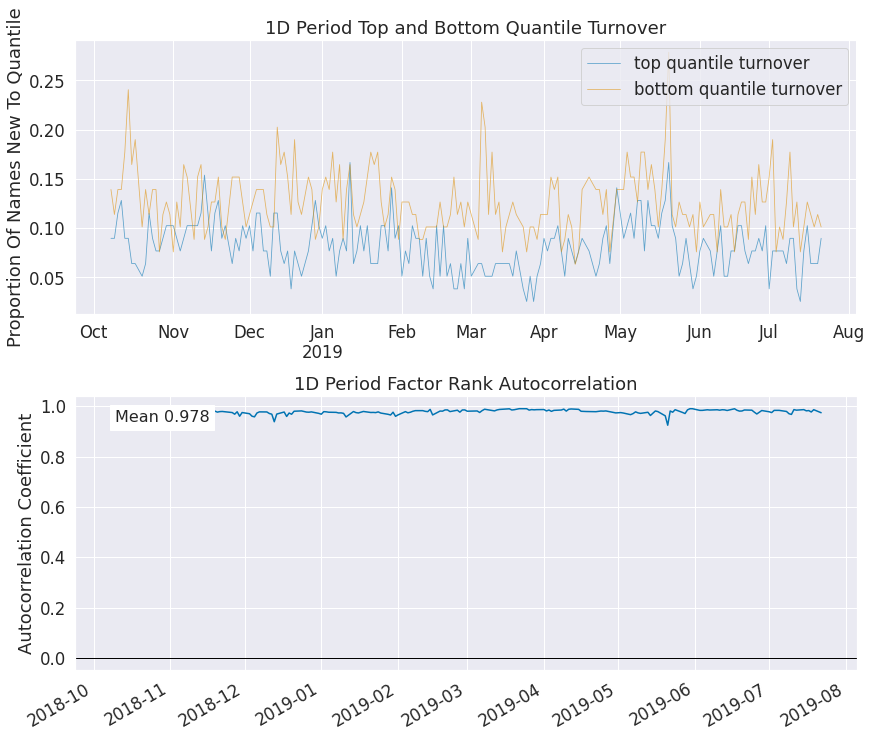


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    2.04
Momentum_1YR                              0.75
Overnight_Sentiment_Smoothed             -2.41
time_beta                                -0.04
time_gamma                                1.40
AI_Alpha                                  1.06
dtype: float64


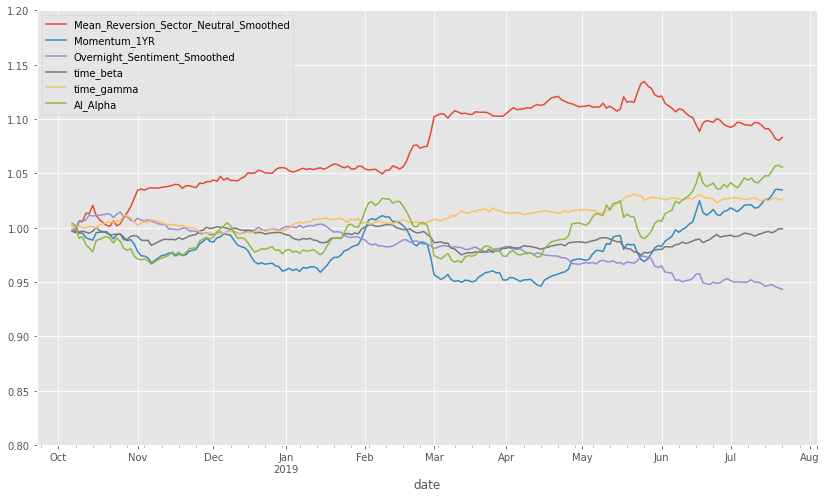

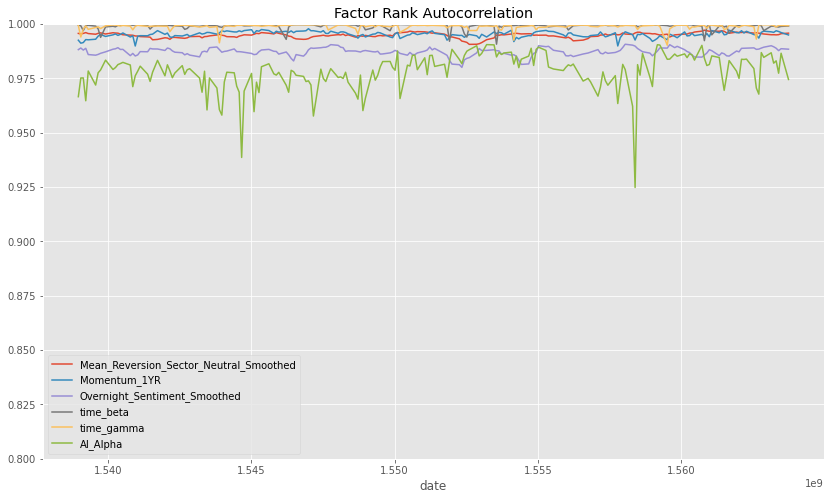

In [22]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [23]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|██████████| 5/5 [04:09<00:00, 49.95s/Model]


#### Results

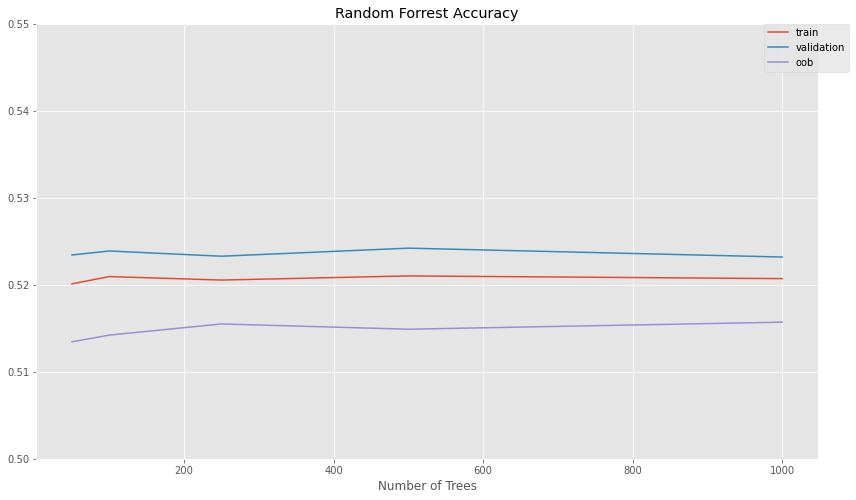

In [24]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

#### Train :

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.044490 -0.009623 -0.024402  0.006415  46373  20.204604
2               -0.024762 -0.001065 -0.011641  0.004166  45786  19.948849
3               -0.013977  0.007134 -0.003033  0.003764  45786  19.948849
4               -0.004837  0.016789  0.006238  0.004129  45786  19.948849
5                0.004504  0.040981  0.019684  0.006234  45786  19.948849

Returns Analysis


1D
Ann. alpha                                     0.100
beta                                          -0.138
Mean Period Wise Return Top Quantile (bps)     2.907
Mean Period Wise Return Bottom Quantile (bps) -3.339
Mean Period Wise Spread (bps)                  6.246

<Figure size 1008x576 with 0 Axes>

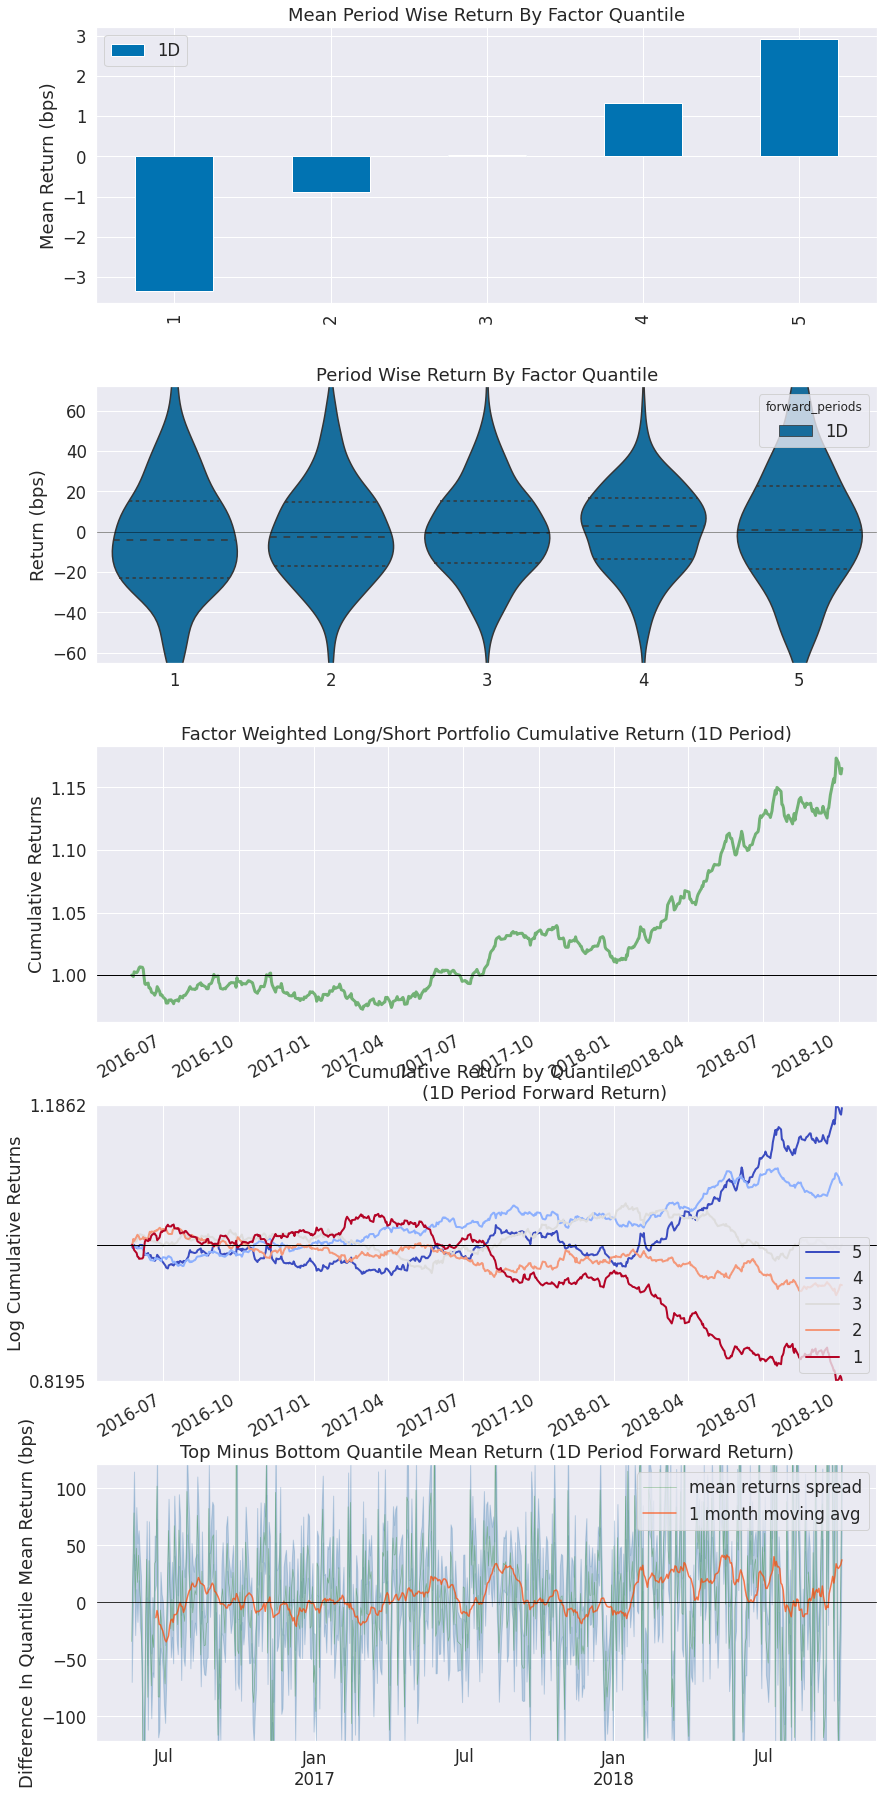

Information Analysis


1D
IC Mean           0.035
IC Std.           0.100
Risk-Adjusted IC  0.348
t-stat(IC)        8.443
p-value(IC)       0.000
IC Skew          -0.011
IC Kurtosis       0.138

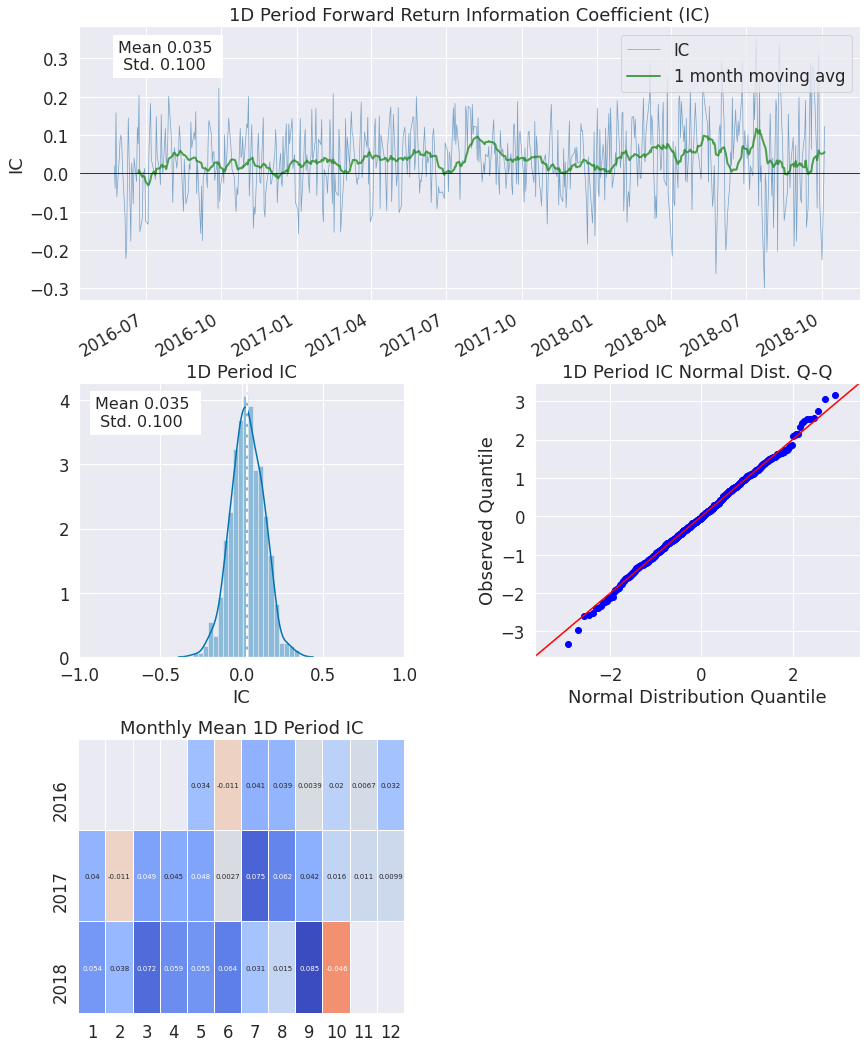

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.082
Quantile 2 Mean Turnover   0.202
Quantile 3 Mean Turnover   0.235
Quantile 4 Mean Turnover   0.204
Quantile 5 Mean Turnover   0.087

1D
Mean Factor Rank Autocorrelation  0.983

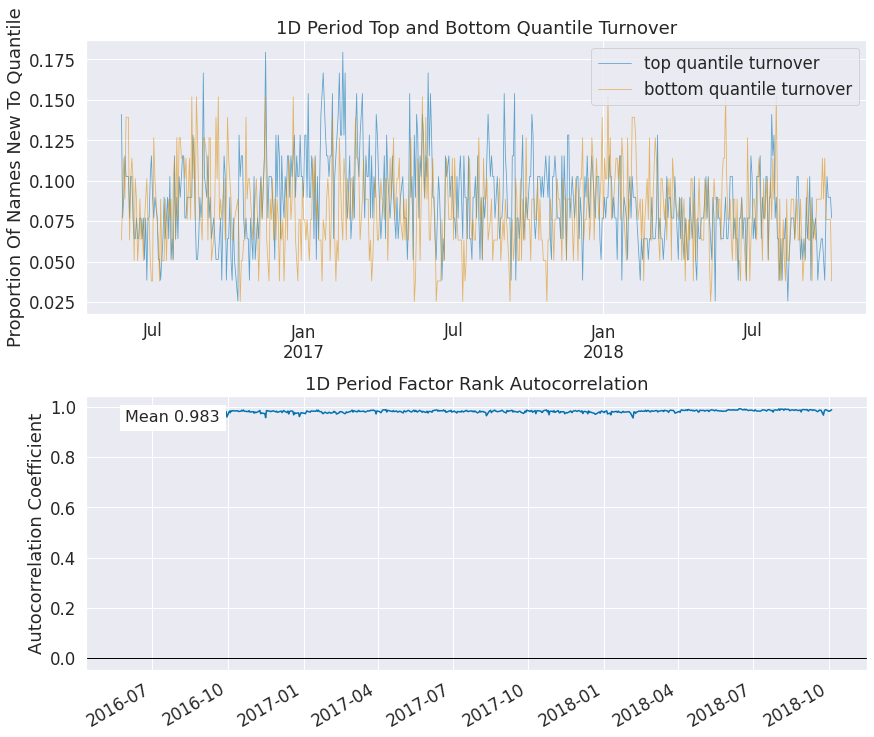


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed   -0.67
Momentum_1YR                              2.33
Overnight_Sentiment_Smoothed              1.16
time_beta                                 0.63
time_gamma                                0.04
AI_Alpha                                  1.69
dtype: float64


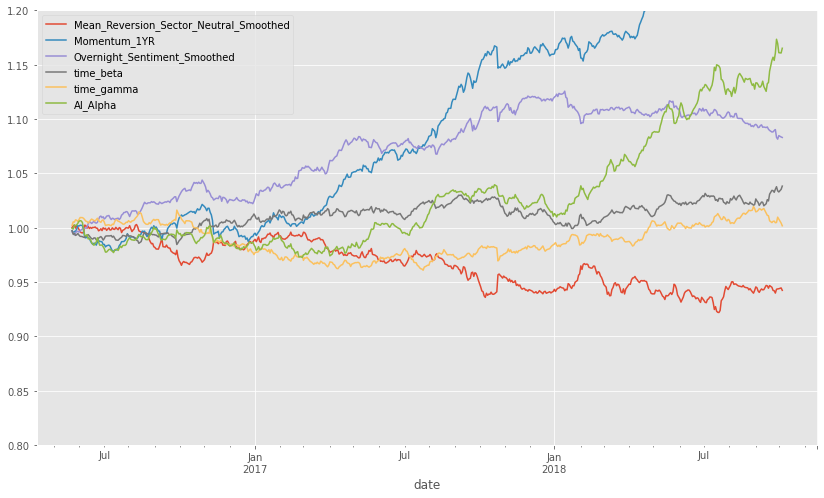

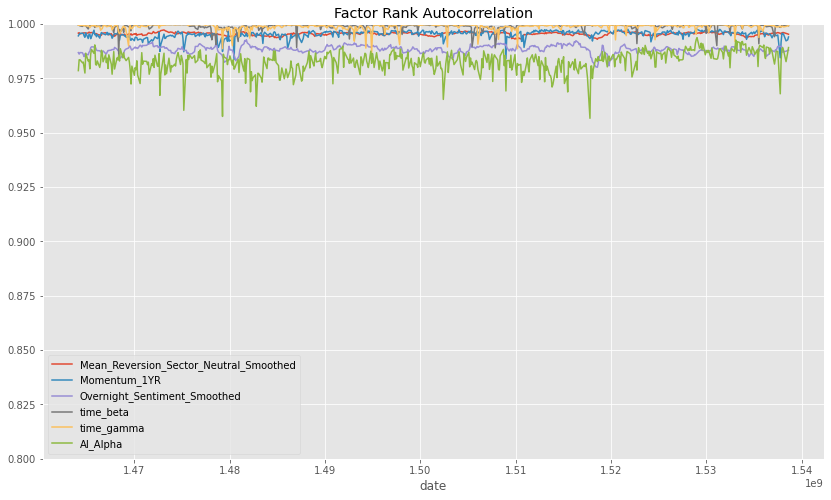

In [25]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.043970 -0.020153 -0.029226  0.004267  15484  20.204604
2               -0.026952 -0.011604 -0.018739  0.002921  15288  19.948849
3               -0.016091 -0.001624 -0.009519  0.002877  15288  19.948849
4               -0.007857  0.010671 -0.000013  0.003546  15288  19.948849
5               -0.000122  0.039618  0.015088  0.008016  15288  19.948849

Returns Analysis


1D
Ann. alpha                                     0.071
beta                                          -0.288
Mean Period Wise Return Top Quantile (bps)     1.267
Mean Period Wise Return Bottom Quantile (bps) -4.064
Mean Period Wise Spread (bps)                  5.331

<Figure size 1008x576 with 0 Axes>

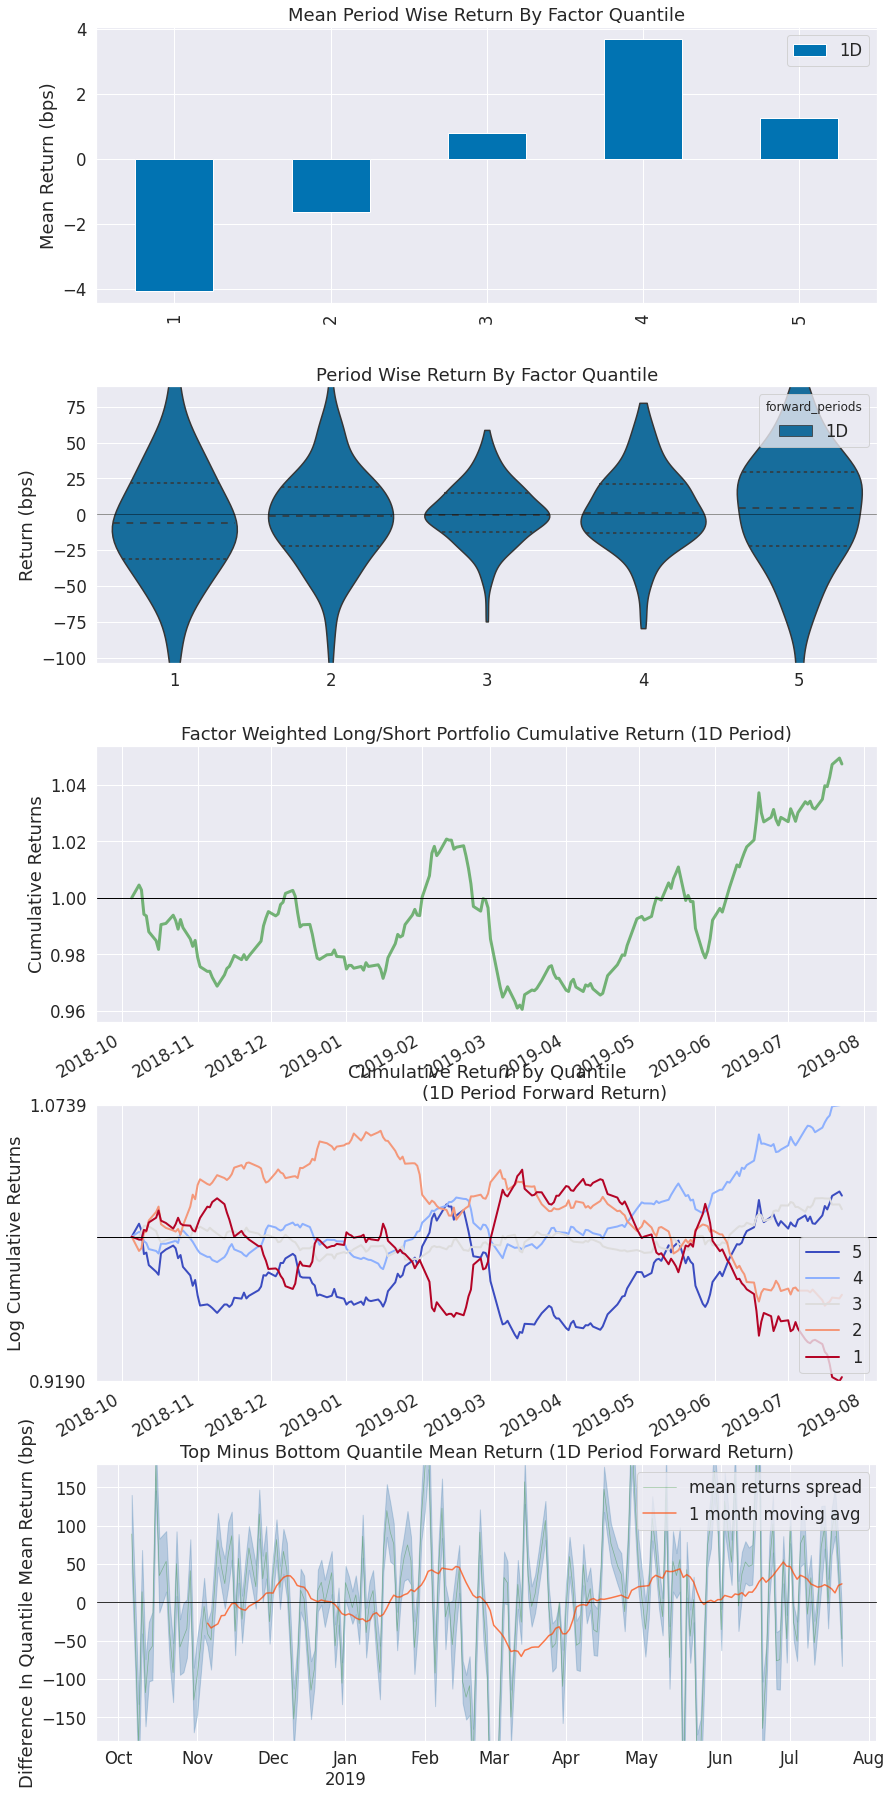

Information Analysis


1D
IC Mean           0.044
IC Std.           0.144
Risk-Adjusted IC  0.303
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

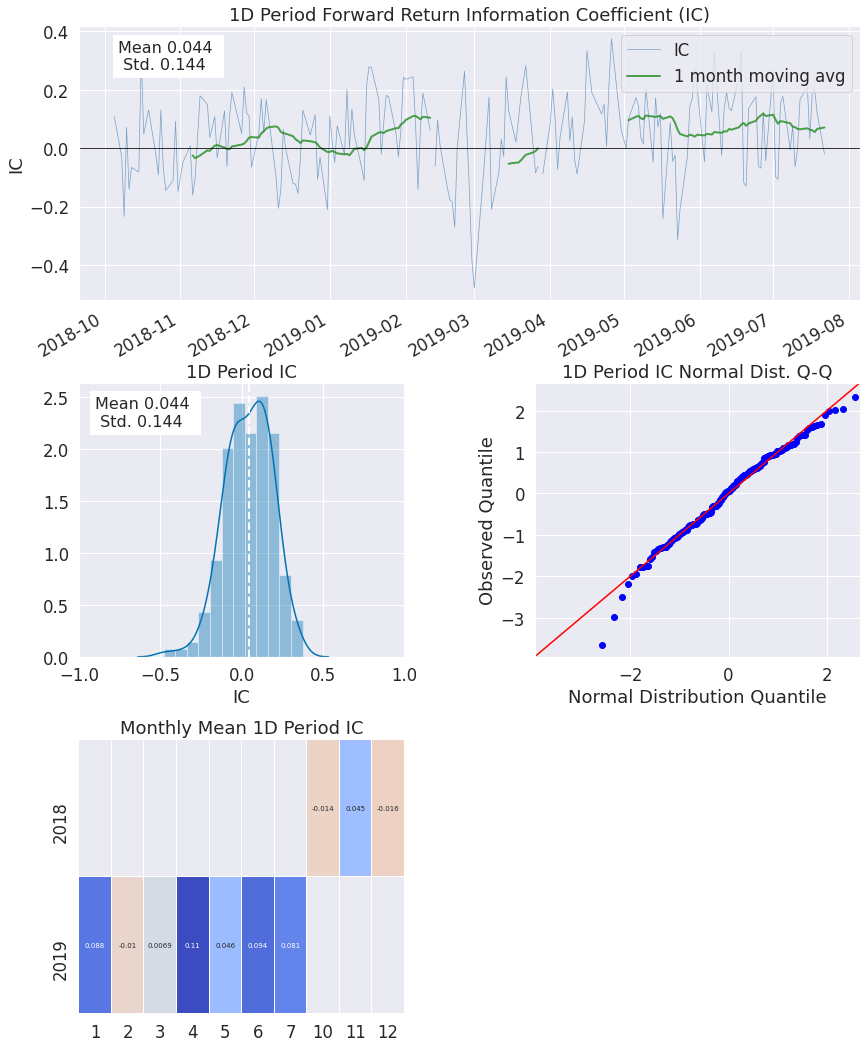

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.090
Quantile 2 Mean Turnover   0.193
Quantile 3 Mean Turnover   0.206
Quantile 4 Mean Turnover   0.177
Quantile 5 Mean Turnover   0.074

1D
Mean Factor Rank Autocorrelation  0.986

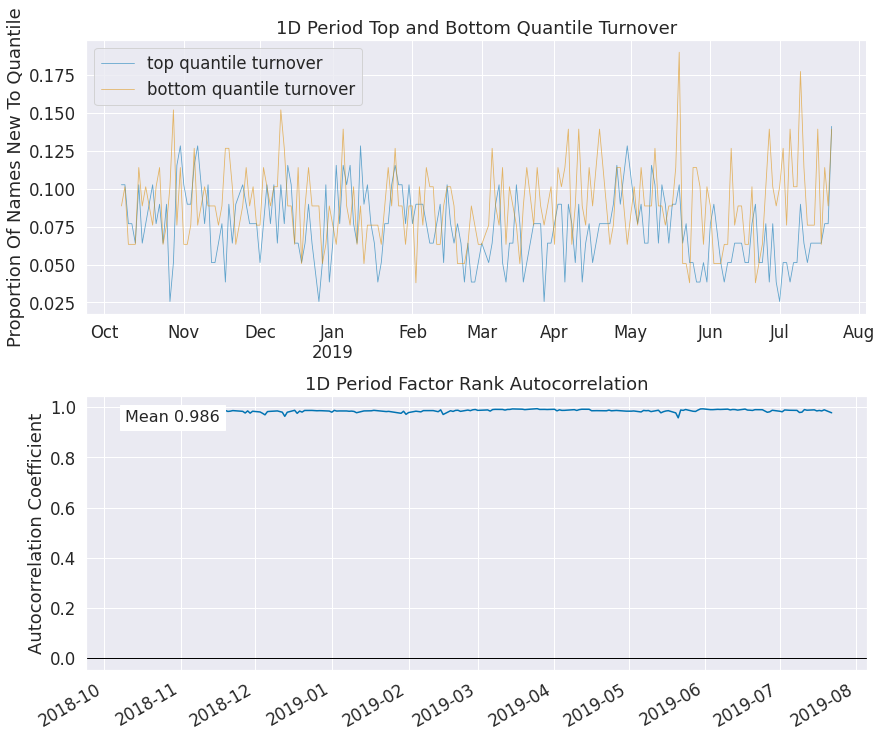


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    2.04
Momentum_1YR                              0.75
Overnight_Sentiment_Smoothed             -2.41
time_beta                                -0.04
time_gamma                                1.40
AI_Alpha                                  1.00
dtype: float64


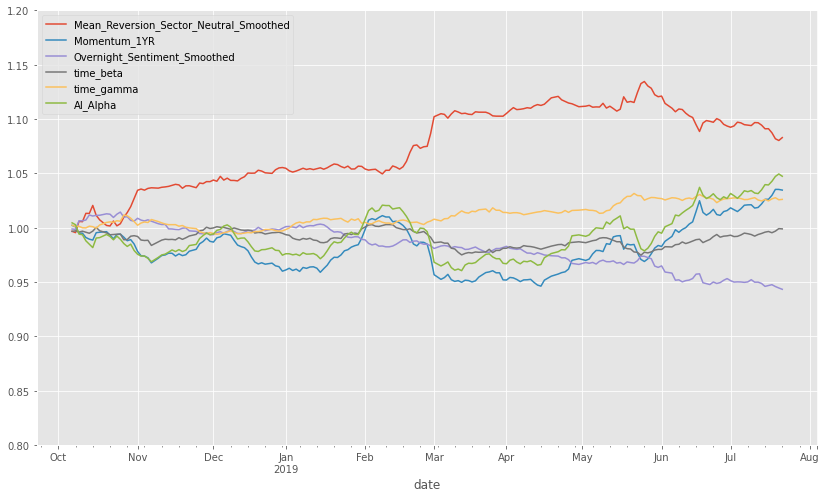

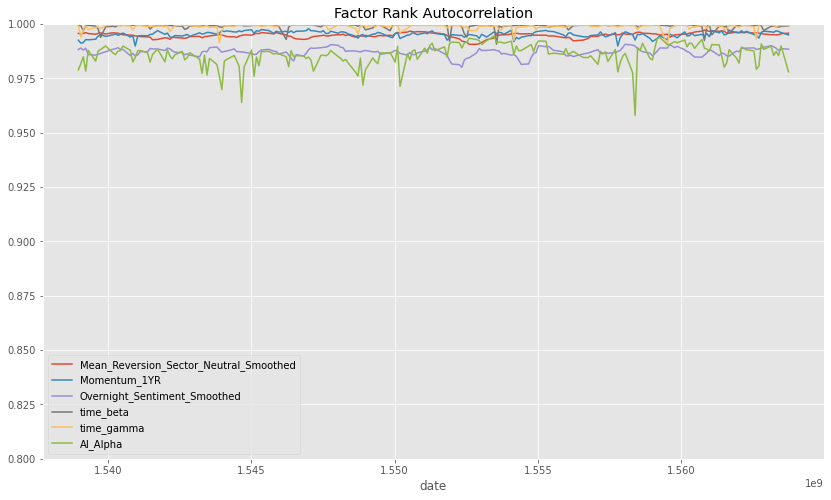

In [26]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [27]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None)

### Results
#### Accuracy

In [28]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.5187857751796371, oob: 0.5297249334516415, valid: 0.5170973516901808


#### Train

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.057089 -0.012368 -0.028421  0.008858  46373  20.204604
2               -0.028823 -0.001070 -0.012707  0.004511  45786  19.948849
3               -0.014094  0.010142 -0.001927  0.004215  45786  19.948849
4               -0.001839  0.021355  0.010265  0.004532  45786  19.948849
5                0.008406  0.049649  0.026374  0.006954  45786  19.948849

Returns Analysis


1D
Ann. alpha                                     0.078
beta                                          -0.180
Mean Period Wise Return Top Quantile (bps)     2.016
Mean Period Wise Return Bottom Quantile (bps) -1.148
Mean Period Wise Spread (bps)                  3.163

<Figure size 1008x576 with 0 Axes>

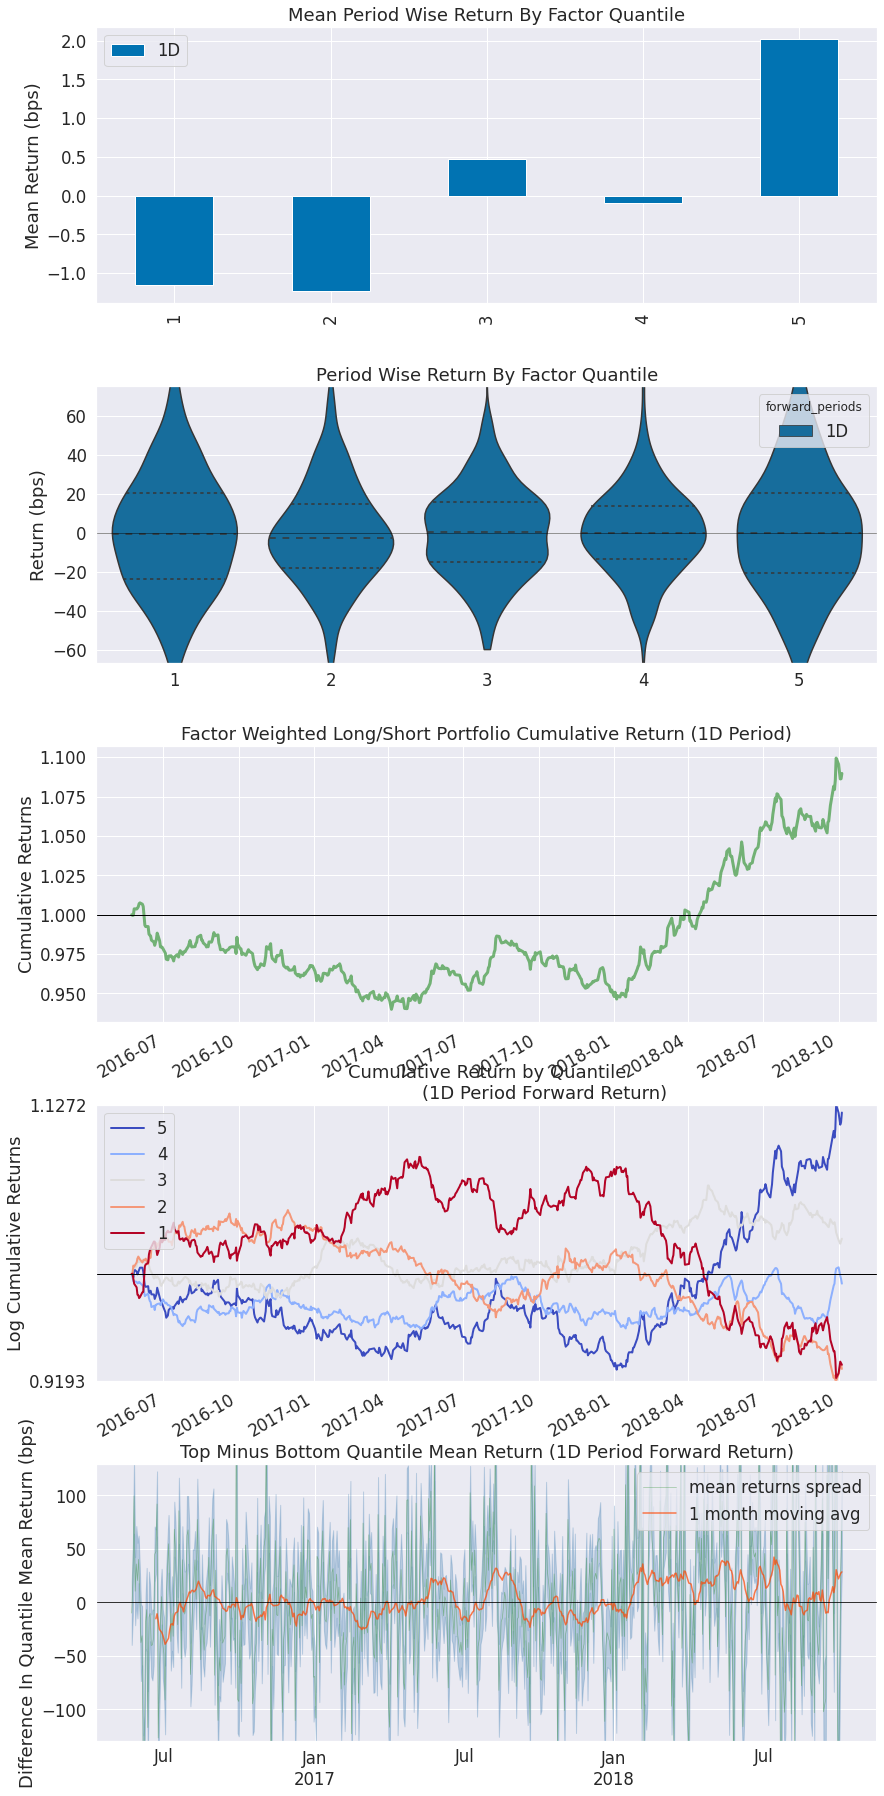

Information Analysis


1D
IC Mean           0.035
IC Std.           0.109
Risk-Adjusted IC  0.322
t-stat(IC)        7.799
p-value(IC)       0.000
IC Skew           0.098
IC Kurtosis       0.068

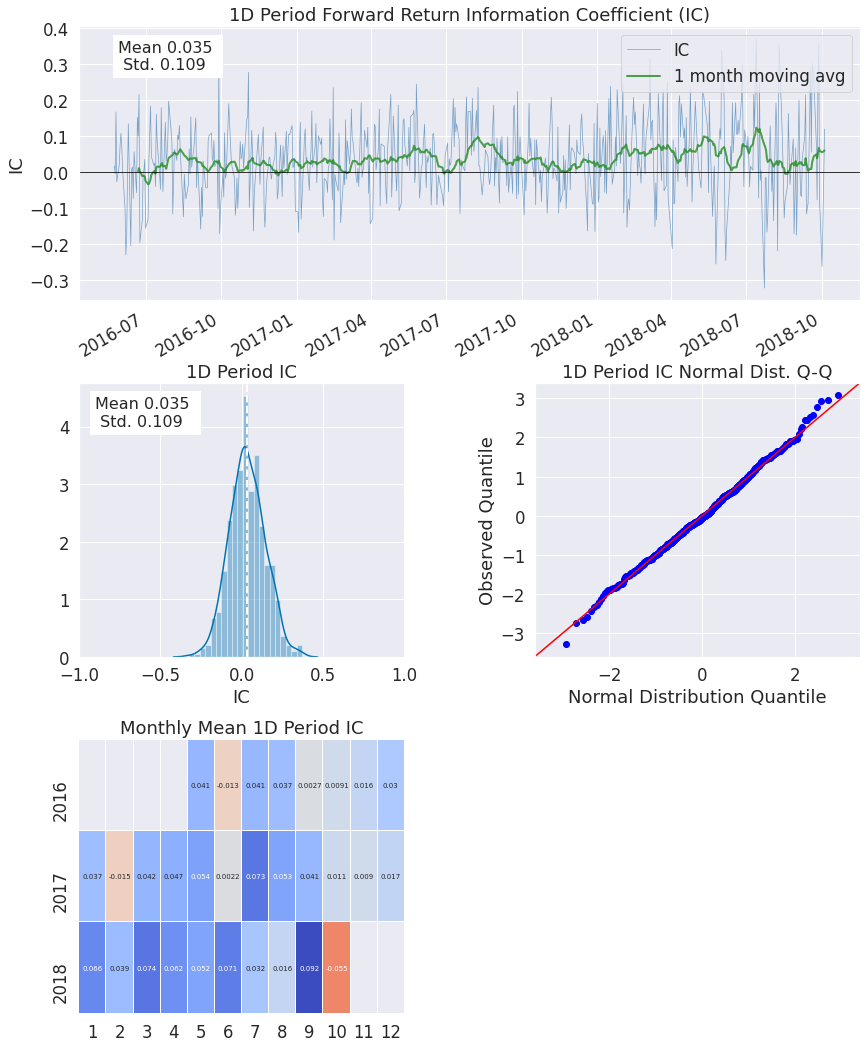

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.088
Quantile 2 Mean Turnover   0.204
Quantile 3 Mean Turnover   0.219
Quantile 4 Mean Turnover   0.185
Quantile 5 Mean Turnover   0.081

1D
Mean Factor Rank Autocorrelation  0.984

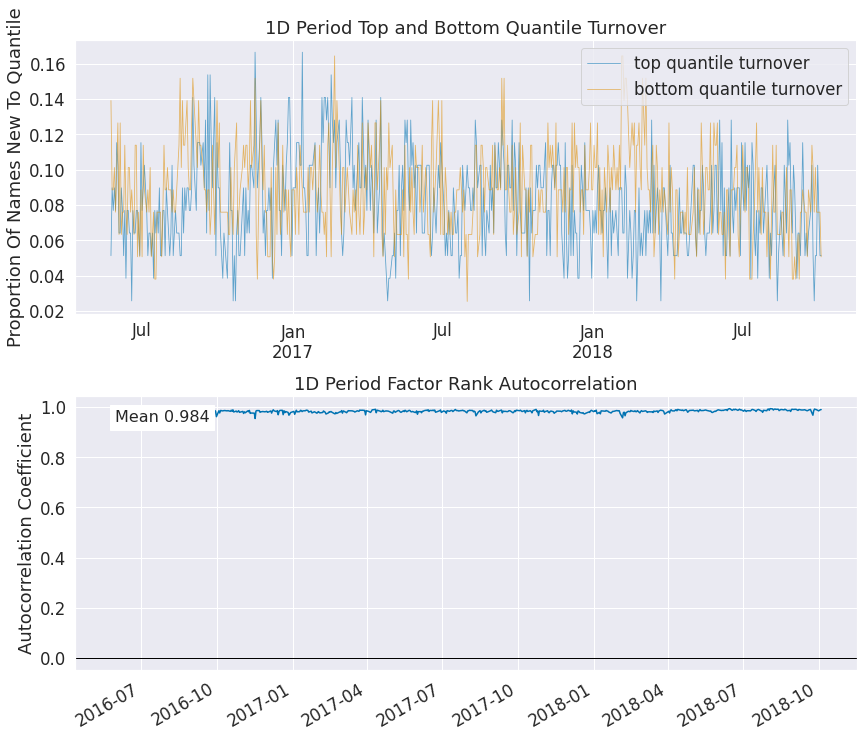


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed   -0.67
Momentum_1YR                              2.33
Overnight_Sentiment_Smoothed              1.16
time_beta                                 0.63
time_gamma                                0.04
AI_Alpha                                  0.88
dtype: float64


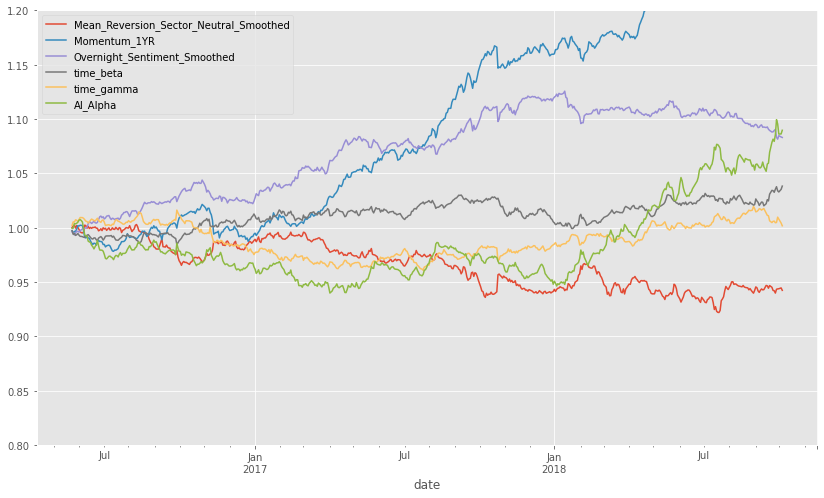

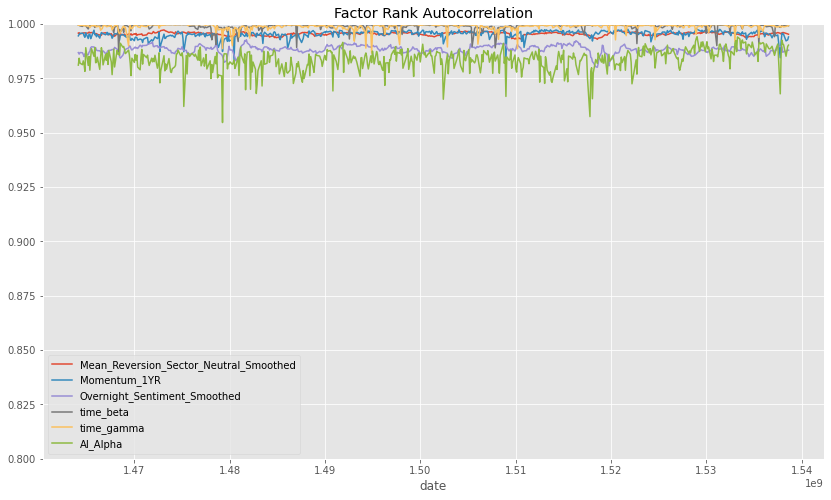

In [29]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.057360 -0.021153 -0.035288  0.006407  15484  20.204604
2               -0.033438 -0.010476 -0.020494  0.004342  15288  19.948849
3               -0.017599  0.002478 -0.007737  0.004017  15288  19.948849
4               -0.005214  0.020081  0.005497  0.005058  15288  19.948849
5                0.006310  0.049929  0.023781  0.008770  15288  19.948849

Returns Analysis


1D
Ann. alpha                                     0.120
beta                                          -0.293
Mean Period Wise Return Top Quantile (bps)     3.017
Mean Period Wise Return Bottom Quantile (bps) -6.862
Mean Period Wise Spread (bps)                  9.878

<Figure size 1008x576 with 0 Axes>

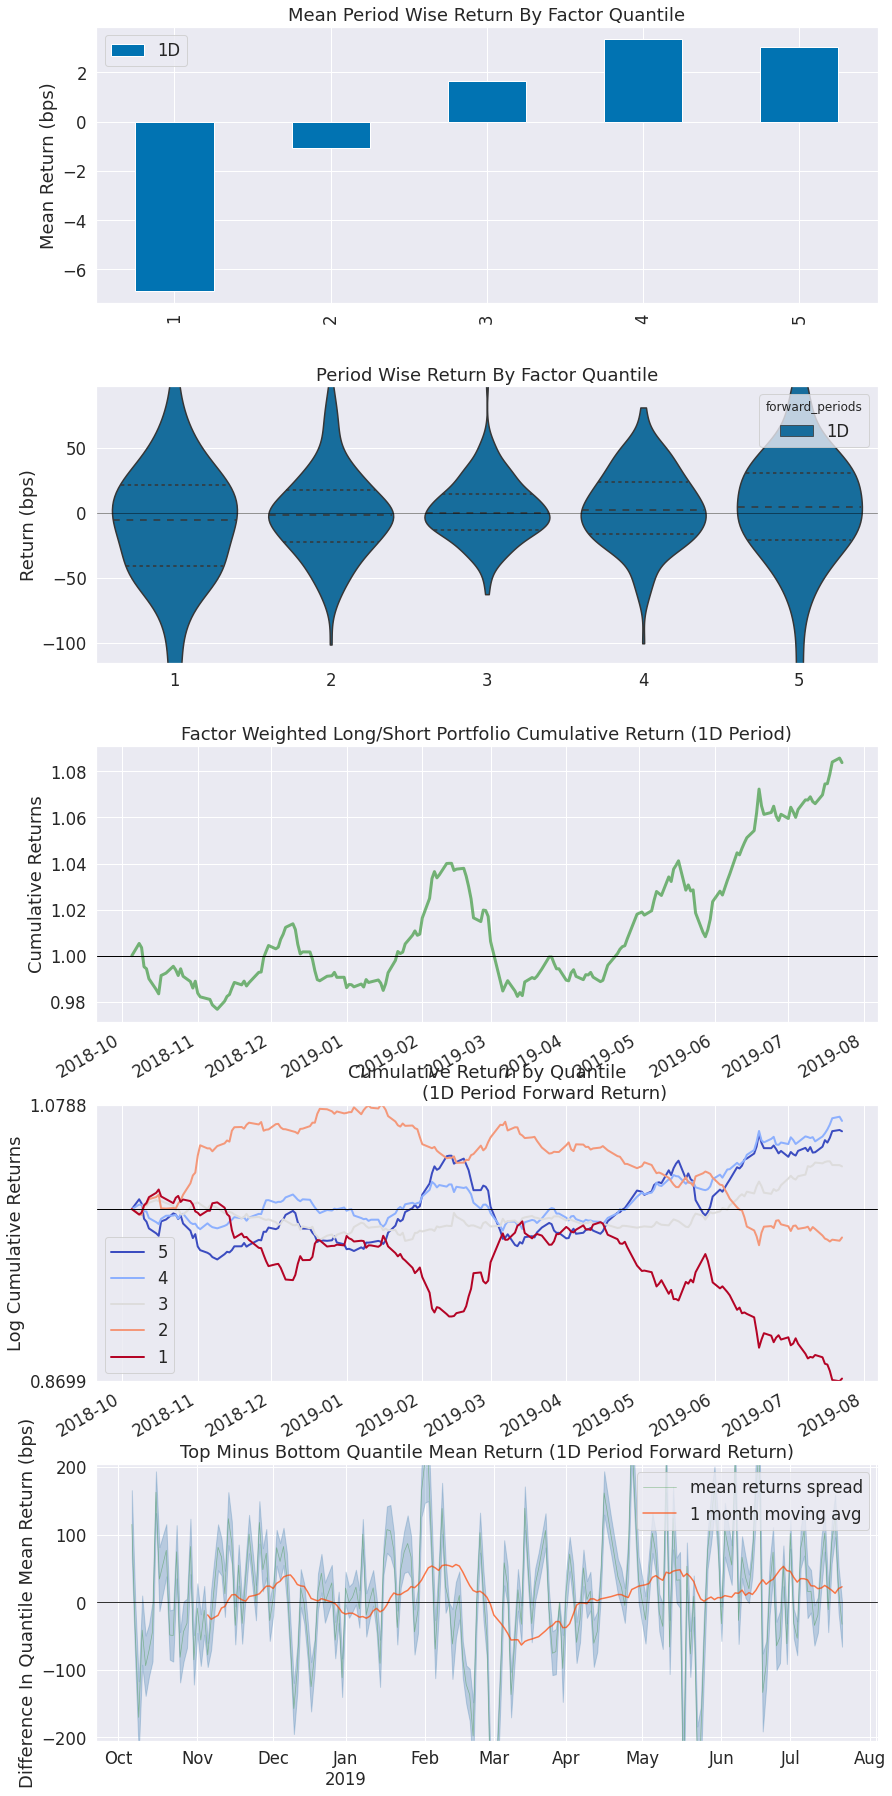

Information Analysis


1D
IC Mean           0.052
IC Std.           0.149
Risk-Adjusted IC  0.349
t-stat(IC)          NaN
p-value(IC)         NaN
IC Skew             NaN
IC Kurtosis         NaN

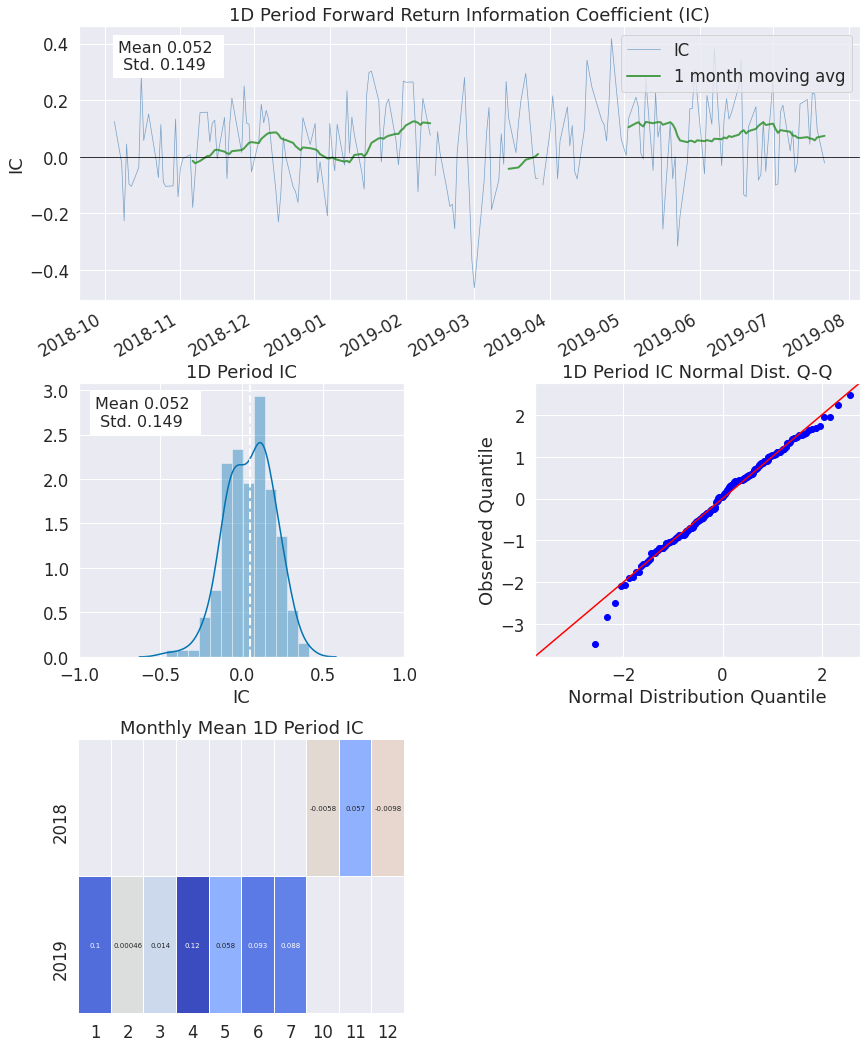

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.080
Quantile 2 Mean Turnover   0.171
Quantile 3 Mean Turnover   0.186
Quantile 4 Mean Turnover   0.158
Quantile 5 Mean Turnover   0.063

1D
Mean Factor Rank Autocorrelation  0.989

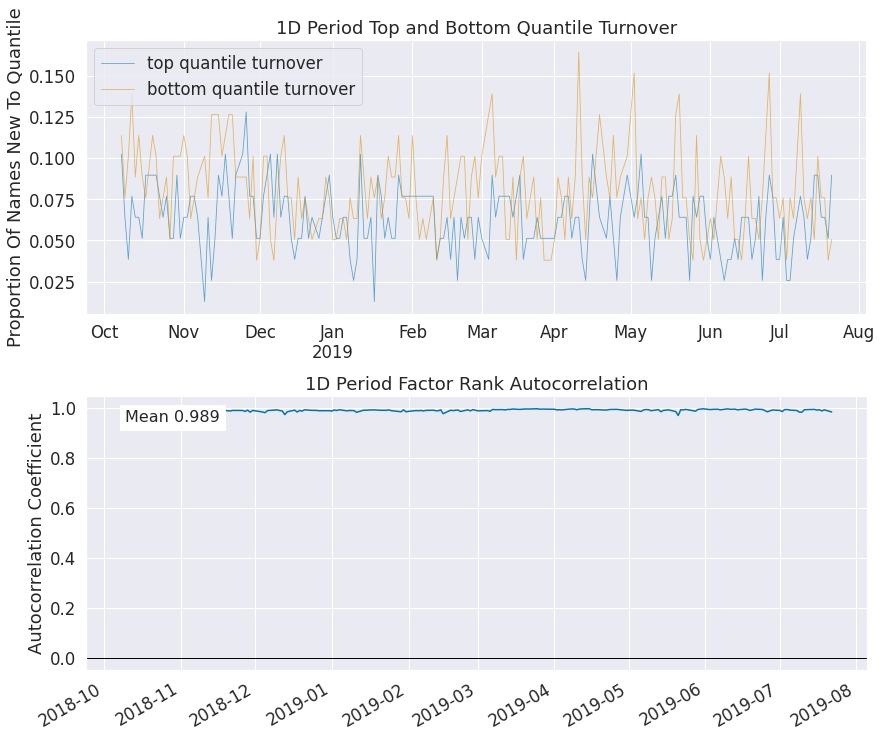


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed    2.04
Momentum_1YR                              0.75
Overnight_Sentiment_Smoothed             -2.41
time_beta                                -0.04
time_gamma                                1.40
AI_Alpha                                  1.69
dtype: float64


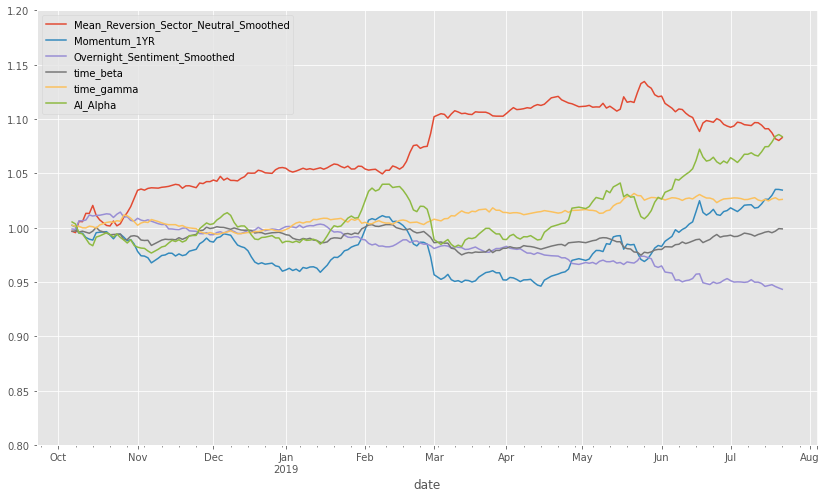

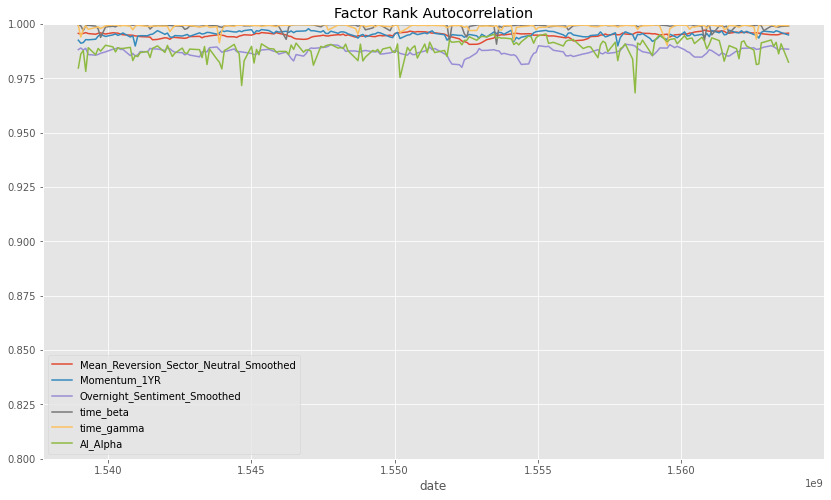

In [30]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

Cleaning Data...

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.054774 -0.022309 -0.034964  0.006317  15484  20.204604
2               -0.030423 -0.009342 -0.019944  0.004209  15288  19.948849
3               -0.019149  0.006365 -0.007255  0.004854  15288  19.948849
4               -0.009808  0.021230  0.005232  0.006097  15288  19.948849
5               -0.002236  0.046372  0.021440  0.009635  15288  19.948849

Returns Analysis


1D
Ann. alpha                                      0.190
beta                                           -0.075
Mean Period Wise Return Top Quantile (bps)      7.668
Mean Period Wise Return Bottom Quantile (bps) -10.552
Mean Period Wise Spread (bps)                  18.221

<Figure size 1008x576 with 0 Axes>

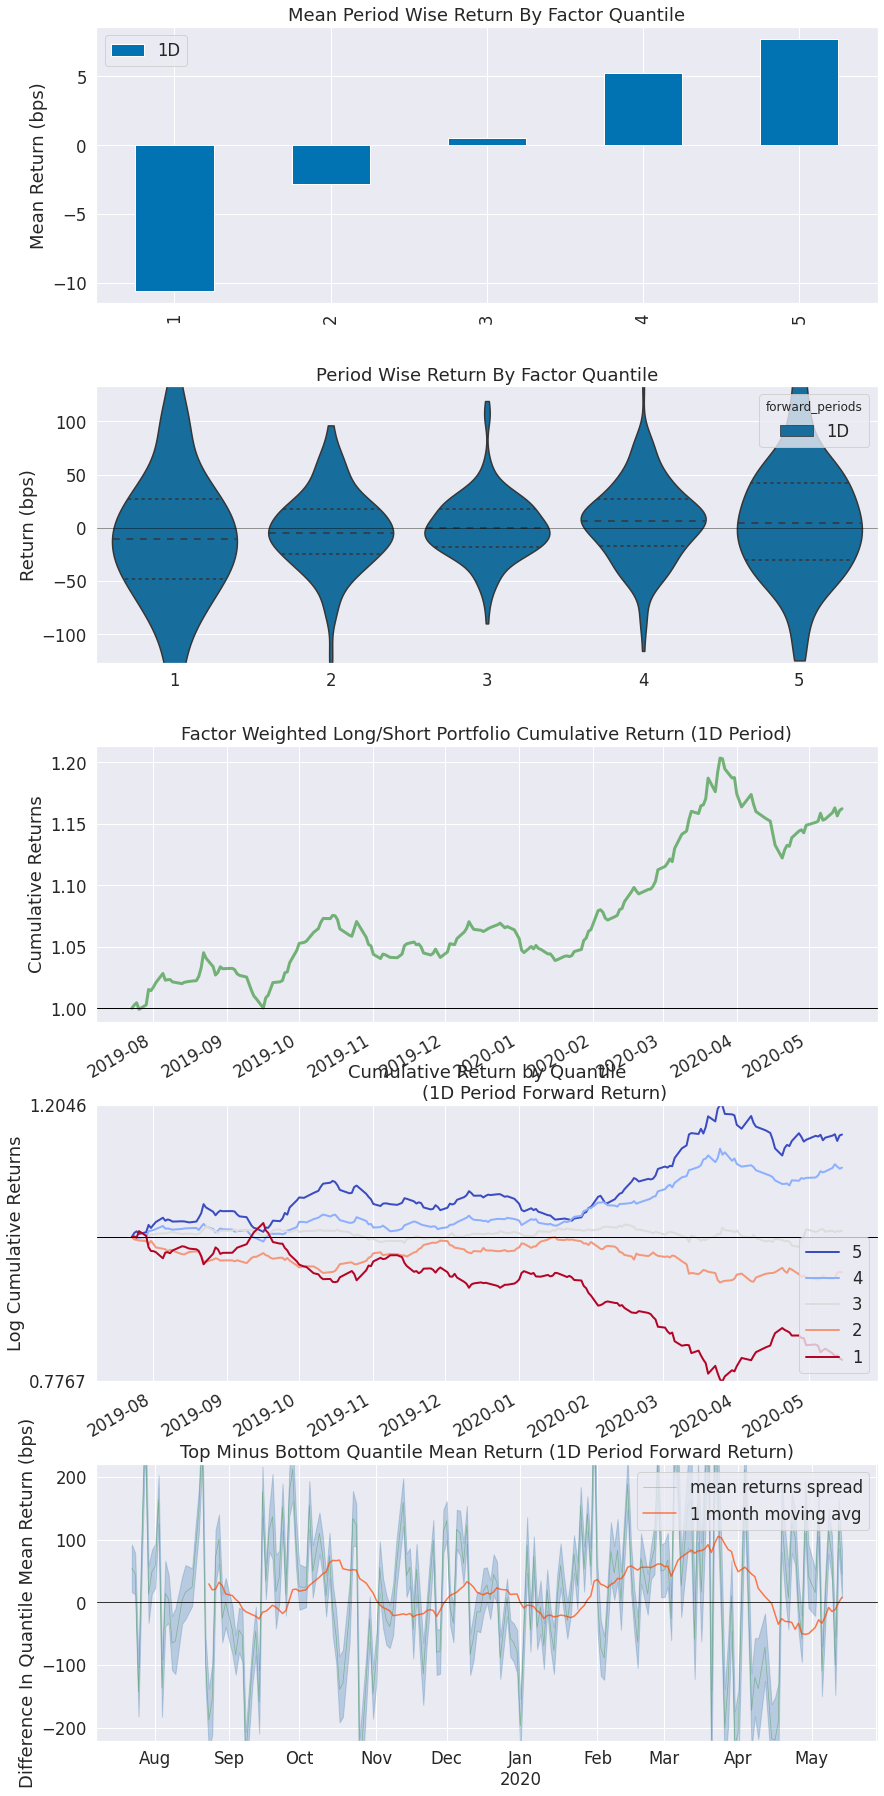

Information Analysis


1D
IC Mean           0.058
IC Std.           0.150
Risk-Adjusted IC  0.387
t-stat(IC)        5.423
p-value(IC)       0.000
IC Skew          -0.042
IC Kurtosis      -0.533

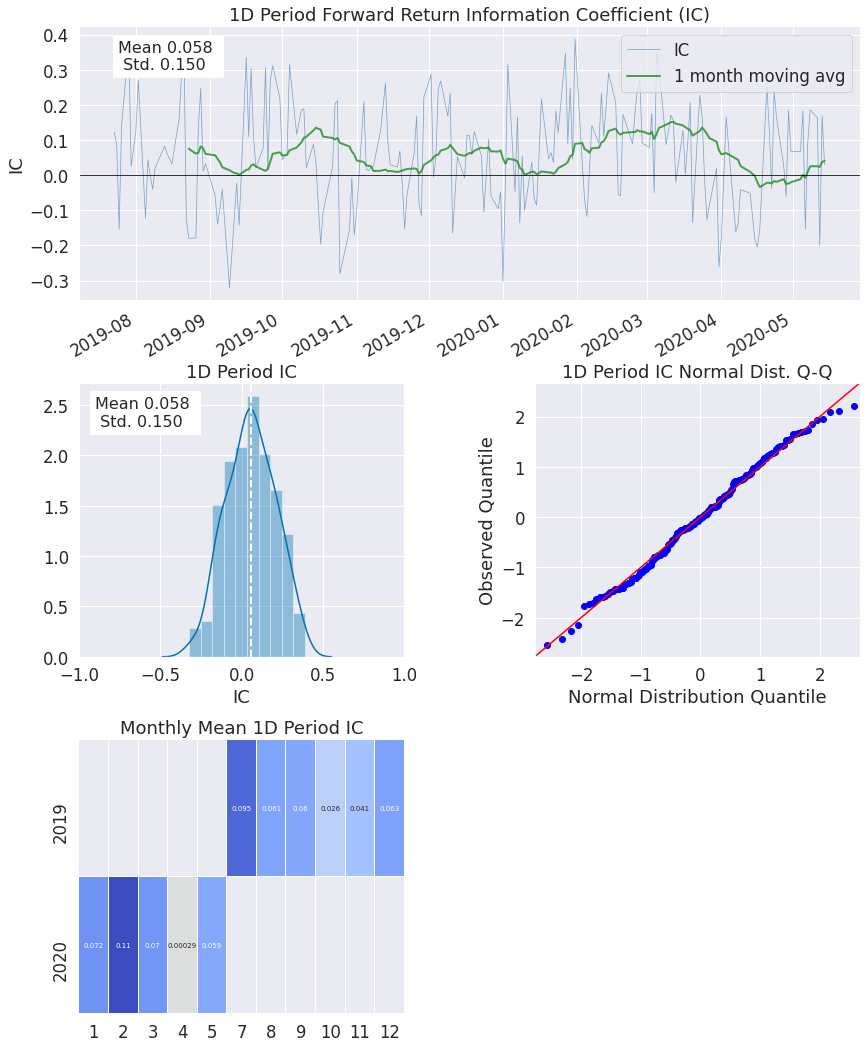

Turnover Analysis


1D
Quantile 1 Mean Turnover   0.077
Quantile 2 Mean Turnover   0.168
Quantile 3 Mean Turnover   0.183
Quantile 4 Mean Turnover   0.164
Quantile 5 Mean Turnover   0.072

1D
Mean Factor Rank Autocorrelation  0.988

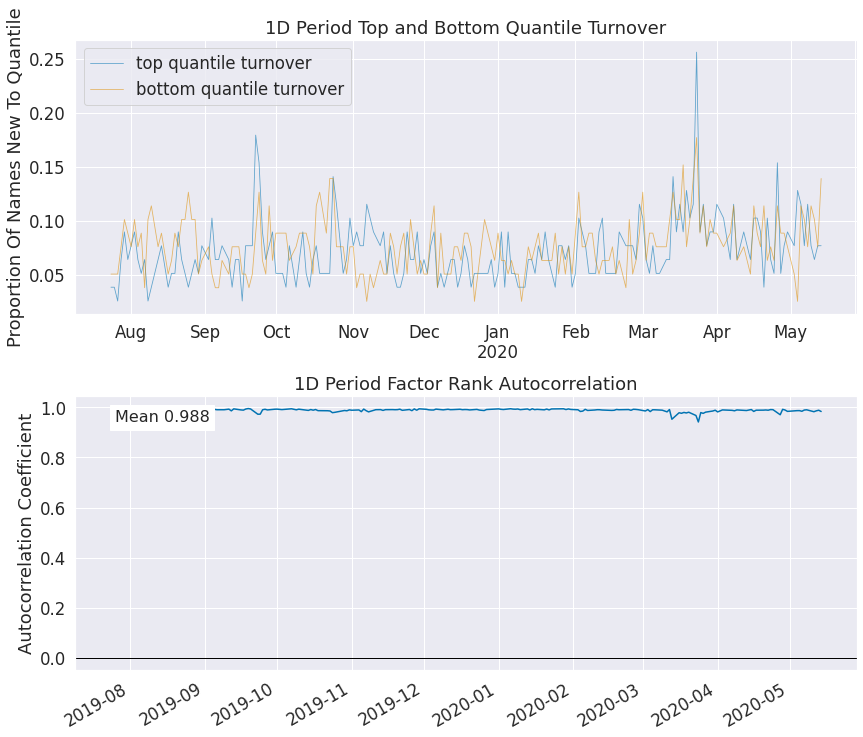


--------------------------------------------------------

             Sharpe Ratios
Mean_Reversion_Sector_Neutral_Smoothed   -0.21
Momentum_1YR                              2.01
Overnight_Sentiment_Smoothed              2.01
time_beta                                 1.99
time_gamma                               -0.00
AI_Alpha                                  2.57
dtype: float64


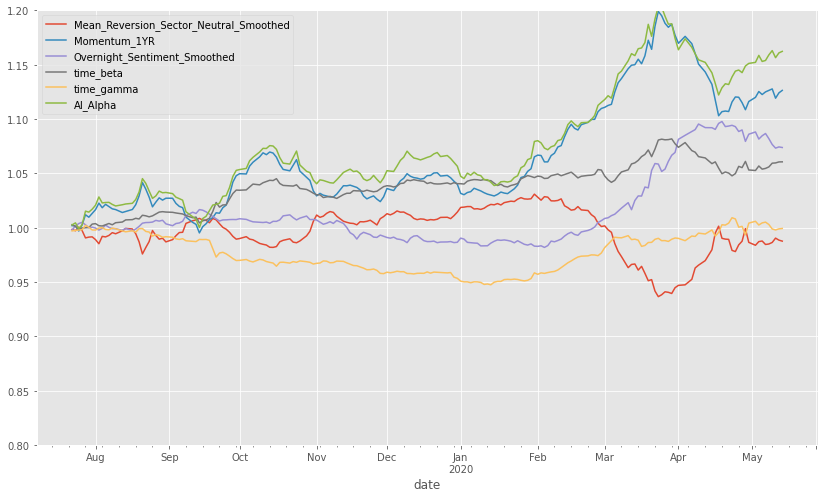

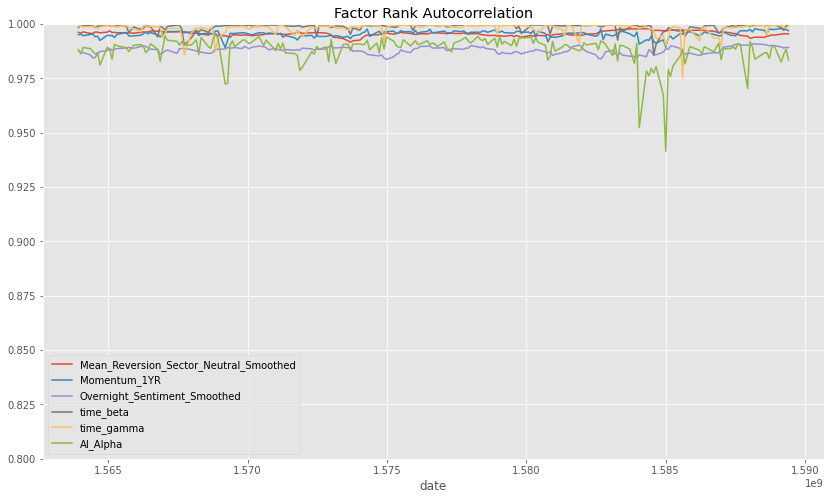

In [31]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

Despite the significant differences between the factor performances in the three sets, the AI APLHA is able to deliver positive performance.

## Getting Predictions Of AI Alpha And Saving

In [32]:
def save_alpha(data,samples,classifier,factors):
    prob_array = [-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    alpha_score_label = 'AI_Alpha'
    factors_with_alpha = samples.copy()
    factors_with_alpha[alpha_score_label] = alpha_score

    return factors_with_alpha[factors + [alpha_score_label]]

In [33]:
factors_with_alpha = save_alpha(all_factors,X_test,clf_nov,factor_names)

# Advanced Portfolio Optimization :

# Statistical Risk Model
It's time to build the risk model. Creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
`fit_pca` function in `risk_model.py` to fit a PCA model to the returns data 

## Factor Betas
`factor_betas` function in `risk_model.py` to get the factor betas from the PCA model.

## Factor Returns
`factor_returns` function in `risk_model.py` to get the factor returns from the PCA model using the returns data.

## Factor Covariance Matrix
`factor_cov_matrix` function in `risk_model.py` to get the factor covariance matrix.

## Idiosyncratic Variance Matrix
`idiosyncratic_var_matrix` function in `risk_model.py` to get the idiosyncratic variance matrix.

## Idiosyncratic Variance Vector
`idiosyncratic_var_vector` function in `risk_model.py` to get the idiosyncratic variance Vector.

## The Risk Model
Using the data we calculated in the risk model,to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

# Optimal Portfolio Constrained by Risk Model
We have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model.

## Objective and Constraints
Using `AbstractOptimalHoldings` in `portfolio_optimizer.py` as a base class, the `OptimalHoldings` in `portfolio_optimizer.py` class. There's two functions that is implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. This class, `OptimalHoldingsStrictFactor` in `portfolio_optimizer.py`, the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

## Now Optimizing The AI Alpha Factor :
Since we don't want to leak data we are creating a risk model for every day and optimizing the portfolio weights for everyday

In [34]:
def get_optimized_portfolio_weights(all_pricing,factors_with_alpha,assets,start_date,prev_date):
    
    dates = all_pricing.loc[start_date:].index
    
    optimal_portfolio = pd.DataFrame()
    
    for date in tqdm(dates, desc='Optimizing Portfolio', unit='day'):

        alpha_factor = factors_with_alpha['AI_Alpha'].loc[date].values

        alpha_dict = {'asset' : assets,'alpha_vector': alpha_factor}
        
        alpha_vector = pd.DataFrame(alpha_dict).set_index('asset')

        returns = all_pricing.loc[:prev_date].tail(253).pct_change()[1:].fillna(0)

        prev_date = date

        risk_model = risk_modelling(returns)

        optimal_weights = OptimalHoldingsStrictFactor(weights_max=0.02,weights_min=-0.02,risk_cap=0.0015,factor_max=0.015,factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])
        
        optimal_weights.columns = [date]
        
        optimal_portfolio = pd.concat([optimal_portfolio,optimal_weights],axis = 1)
        
        
    return optimal_portfolio

In [35]:
start_date = '2019-07-23' # Initial Trading Date Of Alpha
prev_date = '2019-07-22' # Previous Trading Date For Optimization

In [36]:
optimal_portfolio =  get_optimized_portfolio_weights(all_pricing,factors_with_alpha,all_assets,start_date,prev_date)

Optimizing Portfolio: 100%|██████████| 197/197 [1:31:10<00:00, 27.77s/day]


In [37]:
optimal_portfolio

2019-07-23 00:00:00+00:00  \
asset                                                    
Equity(0 [3MINDIA.NS])                        0.000199   
Equity(1 [AARTIIND.NS])                       0.000433   
Equity(2 [ABBOTINDIA.NS])                     0.000459   
Equity(3 [ABFRL.NS])                          0.000165   
Equity(4 [ACC.NS])                            0.000594   
Equity(5 [ADANIPORTS.NS])                     0.000311   
Equity(6 [ADANIPOWER.NS])                     0.000099   
Equity(7 [AEGISCHEM.NS])                     -0.000127   
Equity(8 [AIAENG.NS])                         0.000304   
Equity(9 [AJANTPHARM.NS])                    -0.000062   
Equity(10 [AKZOINDIA.NS])                    -0.000121   
Equity(11 [ALLCARGO.NS])                     -0.000251   
Equity(12 [AMARAJABAT.NS])                   -0.000250   
Equity(13 [AMBUJACEM.NS])                     0.000329   
Equity(14 [APLAPOLLO.NS])                     0.000002   
Equity(15 [APLLTD.NS])                       -0.000236   
Equity(16 [APOLLOHOSP.NS])                    0.000303   
Equity(17 [APOLLOTYRE.NS])                   -0.000404   
Equity(18 [ASAHIINDIA.NS])                   -0.000420   
Equity(19 [ASHOKA.NS])                       -0.000120   
Equity(20 [ASHOKLEY.NS])                     -0.000014   
Equity(21 [ASIANPAINT.NS])                    0.000376   
Equity(22 [ASTRAL.NS])                        0.000106   
Equity(23 [ASTRAZEN.NS])                     -0.000185   
Equity(24 [ATUL.NS])                          0.000535   
Equity(25 [AUROPHARMA.NS])                   -0.000148   
Equity(26 [AVANTIFEED.NS])                   -0.000082   
Equity(27 [AXISBANK.NS])                      0.000898   
Equity(28 [BAJAJ-AUTO.NS])                    0.000051   
Equity(29 [BAJAJCON.NS])                     -0.000042   
...                                                ...   
Equity(361 [TVSMOTOR.NS])                    -0.000127   
Equity(362 [TVTODAY.NS])                     -0.000584   
Equity(363 [UBL.NS])                          0.000209   
Equity(364 [UCOBANK.NS])                     -0.000152   
Equity(365 [UFLEX.NS])                        0.000269   
Equity(366 [ULTRACEMCO.NS])                   0.000723   
Equity(367 [UNIONBANK.NS])                   -0.000123   
Equity(368 [UPL.NS])                         -0.000055   
Equity(369 [VAIBHAVGBL.NS])                   0.000142   
Equity(370 [VAKRANGEE.NS])                   -0.000062   
Equity(371 [VEDL.NS])                         0.000009   
Equity(372 [VENKEYS.NS])                      0.000063   
Equity(373 [VGUARD.NS])                       0.000121   
Equity(374 [VINATIORGA.NS])                  -0.000057   
Equity(375 [VIPIND.NS])                       0.000241   
Equity(376 [VMART.NS])                       -0.000332   
Equity(377 [VOLTAS.NS])                       0.000556   
Equity(378 [VRLLOG.NS])                      -0.000401   
Equity(379 [VSTIND.NS])                       0.000266   
Equity(380 [VTL.NS])                         -0.000281   
Equity(381 [WABAG.NS])                       -0.000043   
Equity(382 [WABCOINDIA.NS])                  -0.000166   
Equity(383 [WELCORP.NS])                      0.000228   
Equity(384 [WELSPUNIND.NS])                   0.000352   
Equity(385 [WHIRLPOOL.NS])                    0.000395   
Equity(386 [WIPRO.NS])                        0.000678   
Equity(387 [WOCKPHARMA.NS])                  -0.000131   
Equity(388 [ZEEL.NS])                        -0.000233   
Equity(389 [ZENSARTECH.NS])                  -0.000059   
Equity(390 [ZYDUSWELL.NS])                    0.000092   

                             2019-07-24 00:00:00+00:00  \
asset                                                    
Equity(0 [3MINDIA.NS])                        0.000242   
Equity(1 [AARTIIND.NS])                       0.000398   
Equity(2 [ABBOTINDIA.NS])                     0.000469   
Equity(3 [ABFRL.NS])                          0.000161   
Equity(4 [ACC.NS])        

In [38]:
optimal_portfolio.to_csv('optimal_portfolio_weights.csv')